In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import tensorflow as tf
from tensorflow import keras

print("GPU available:", len(tf.config.list_physical_devices('GPU')))

2023-05-31 06:38:46.837784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU available: 1


In [3]:
from data_preprocessing import DataProcessor, Dataset
from model import OCCModel
from autoencoder import MLPAutoencoder
from var_autoencoder import MLPVarAutoencoder
from loss import WeightedMSE

In [4]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

In [5]:
architecture = [((256, 128), (0, 0), (128, 256), (0, 0)), 
                ((256, 128, 128), (0.1, 0.1, 0.1), (128, 128, 256), (0.1, 0.1, 0.1)), 
                ((256, 256, 128), (0.4, 0.2, 0.1), (128, 256, 256), (0.1, 0.1, 0.1)),
                ((128, 64, 64), (0, 0, 0), (64, 64, 128), (0, 0, 0)),
                ((256, 128, 64), (0, 0, 0), (64, 128, 256), (0, 0, 0))]
noise = [0.02, 0.08, 0.2]
latent_dim = [64, 32]
absolute_velocities = [True, False]

In [6]:
def test(av, ld, n, arch, name, legw=1, checkpoint_id=None, epochs=10):
    print(name)
    
    dp = DataProcessor(
        notes_qty=64, 
        include_first_tone=False, 
        absolute_velocities=av)
    
    dset = Dataset(dp, 64)
    
    print('Loading dataset...')
    dset.load_dset(PROJECT_PATH + 'data/dset64.npy', 2000)
    print('Dataset loaded')
    
    autoencoder = MLPAutoencoder(
        input_size=dp.input_size,
        latent_dim=ld,
        noise=n,
        encoder_layers=arch[0],
        encoder_dropout=arch[1],
        decoder_layers=arch[2],
        decoder_dropout=arch[3])
    
    loss = WeightedMSE(
        vel_mask=dp.vel_mask, 
        leg_mask=dp.leg_mask, 
        first_last_mask=dp.first_last_mask, 
        vel_weight=1, 
        leg_weight=legw,
        first_last_weight=1)
    
    model = OCCModel(
        autoencoder=autoencoder,
        dataprocessor=dp,
        dist_weight=1, 
        vel_weight=1, 
        leg_weight=legw
    )
    
    decayed_lr = tf.keras.optimizers.schedules.ExponentialDecay(
        3e-3, 
        100000,
        0.86)
    
    model.compile(
        modelsdir=PROJECT_PATH+'traindata/ae/64',
        name=name, 
        optimizer=keras.optimizers.Adam(learning_rate=decayed_lr),
        loss=loss,
        ckpt_epochs=1
    )
    model.summary()
    
    if checkpoint_id is not None:
        model.restore(checkpoint_id)
    
    print('Start training...')
    model.fit(dset, epochs, 3)

In [ ]:
for ld in range(len(latent_dim)):
    for av in range(len(absolute_velocities)):
        for n in range(len(noise)):
            for a in range(len(architecture)):
                test(absolute_velocities[av], latent_dim[ld], noise[n], architecture[a], f'{ld}{av}{n}{a}')

1024
Loading dataset...


/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:411: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:416: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


Dataset loaded
Start training...
Epoch 1/60
82301/82301 - 287s - loss: 0.2368 - val_loss: 0.2311 - occ_accuracy: 0.1989 - 287s/epoch - 3ms/step
Epoch 2/60
82301/82301 - 281s - loss: 0.2296 - val_loss: 0.2277 - occ_accuracy: 0.1990 - 281s/epoch - 3ms/step
Epoch 3/60
82301/82301 - 282s - loss: 0.2294 - val_loss: 0.2311 - occ_accuracy: 0.1994 - 282s/epoch - 3ms/step
Epoch 4/60
82301/82301 - 282s - loss: 0.2290 - val_loss: 0.2273 - occ_accuracy: 0.1995 - 282s/epoch - 3ms/step
Epoch 5/60
82301/82301 - 283s - loss: 0.2283 - val_loss: 0.2274 - occ_accuracy: 0.1995 - 283s/epoch - 3ms/step
Epoch 6/60
82301/82301 - 282s - loss: 0.2273 - val_loss: 0.2260 - occ_accuracy: 0.1997 - 282s/epoch - 3ms/step
Epoch 7/60
82301/82301 - 282s - loss: 0.2262 - val_loss: 0.2263 - occ_accuracy: 0.1999 - 282s/epoch - 3ms/step
Epoch 8/60
82301/82301 - 283s - loss: 0.2254 - val_loss: 0.2240 - occ_accuracy: 0.1998 - 283s/epoch - 3ms/step
Epoch 9/60
82301/82301 - 283s - loss: 0.2245 - val_loss: 0.2236 - occ_accuracy:

/raid/shumnov/music-style-performer/src/ml/discriminator/data_preprocessing.py:236: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 2, figsize=(10, 10))


82301/82301 - 284s - loss: 0.2203 - val_loss: 0.2186 - occ_accuracy: 0.2009 - 284s/epoch - 3ms/step
Epoch 22/60
82301/82301 - 282s - loss: 0.2202 - val_loss: 0.2187 - occ_accuracy: 0.2009 - 282s/epoch - 3ms/step
Epoch 23/60
82301/82301 - 283s - loss: 0.2200 - val_loss: 0.2205 - occ_accuracy: 0.2005 - 283s/epoch - 3ms/step
Epoch 24/60
82301/82301 - 283s - loss: 0.2198 - val_loss: 0.2184 - occ_accuracy: 0.2010 - 283s/epoch - 3ms/step
Epoch 26/60
82301/82301 - 282s - loss: 0.2197 - val_loss: 0.2181 - occ_accuracy: 0.2010 - 282s/epoch - 3ms/step
Epoch 27/60
82301/82301 - 281s - loss: 0.2196 - val_loss: 0.2183 - occ_accuracy: 0.2009 - 281s/epoch - 3ms/step
Epoch 28/60
82301/82301 - 282s - loss: 0.2195 - val_loss: 0.2180 - occ_accuracy: 0.2011 - 282s/epoch - 3ms/step
Epoch 29/60
82301/82301 - 282s - loss: 0.2194 - val_loss: 0.2179 - occ_accuracy: 0.2011 - 282s/epoch - 3ms/step
Epoch 30/60
82301/82301 - 283s - loss: 0.2194 - val_loss: 0.2180 - occ_accuracy: 0.2010 - 283s/epoch - 3ms/step
Epoc

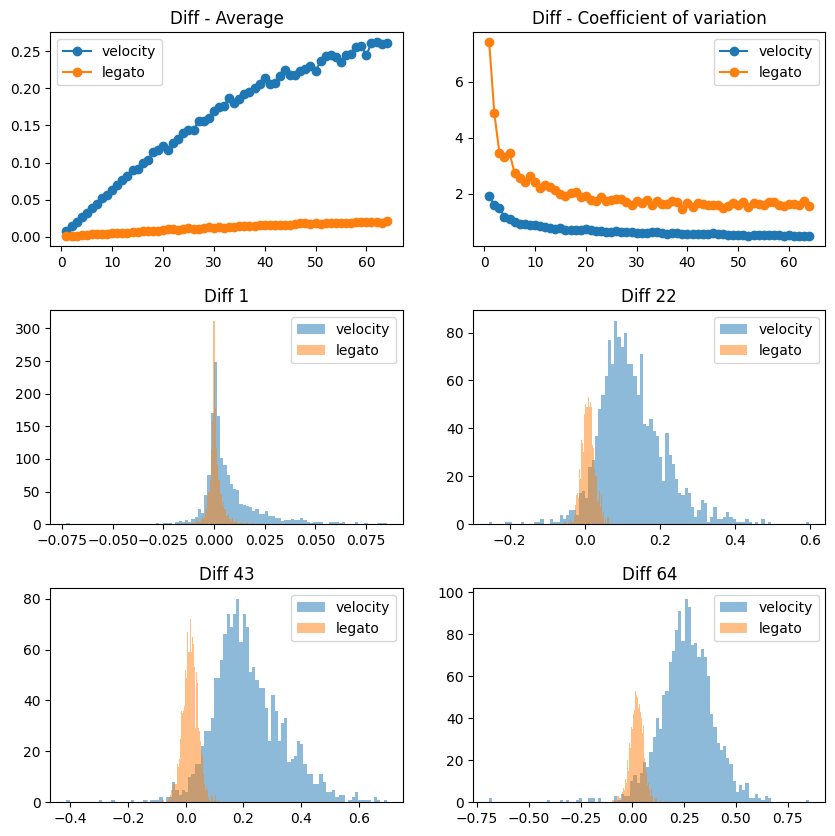

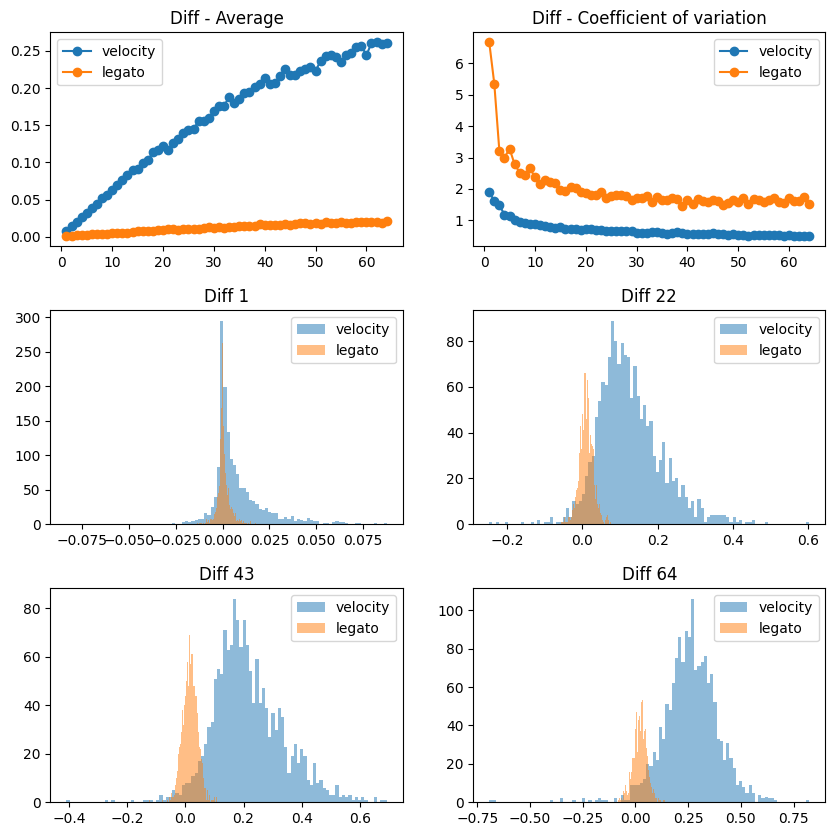

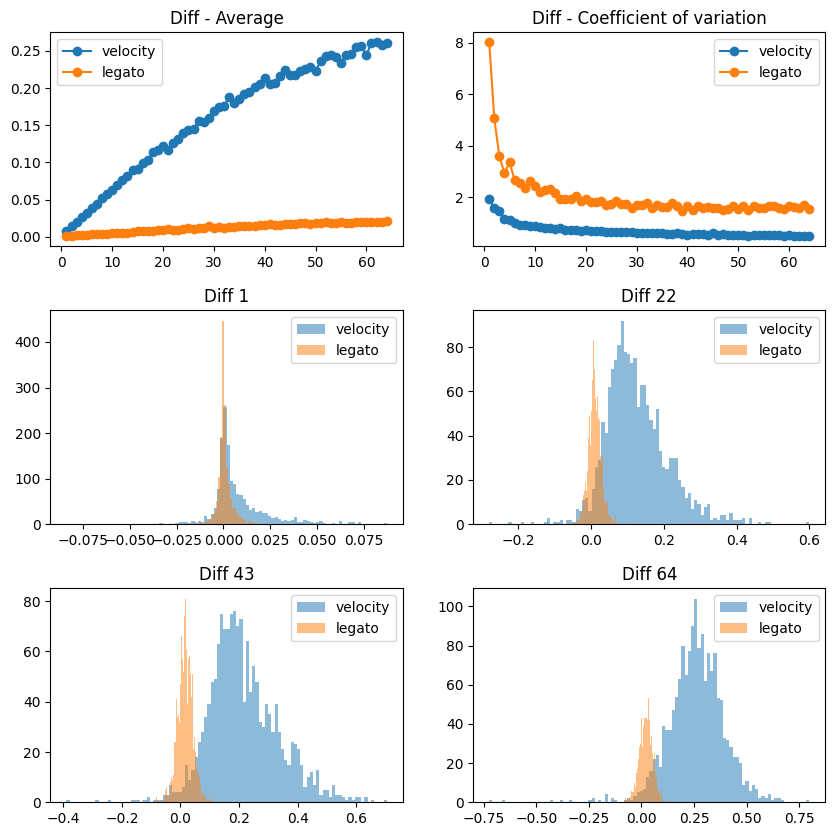

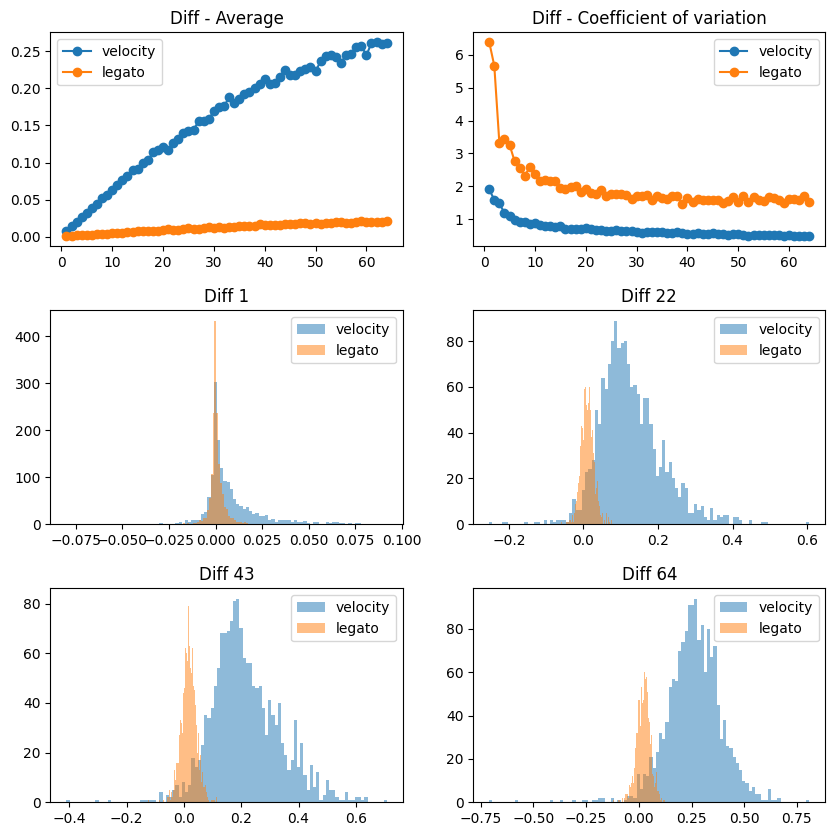

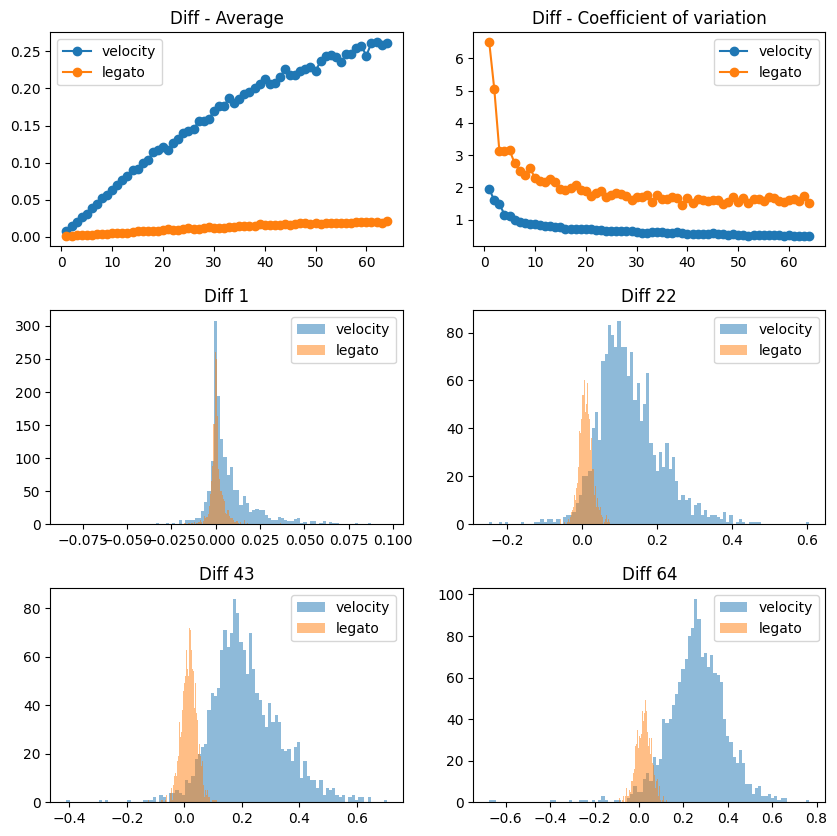

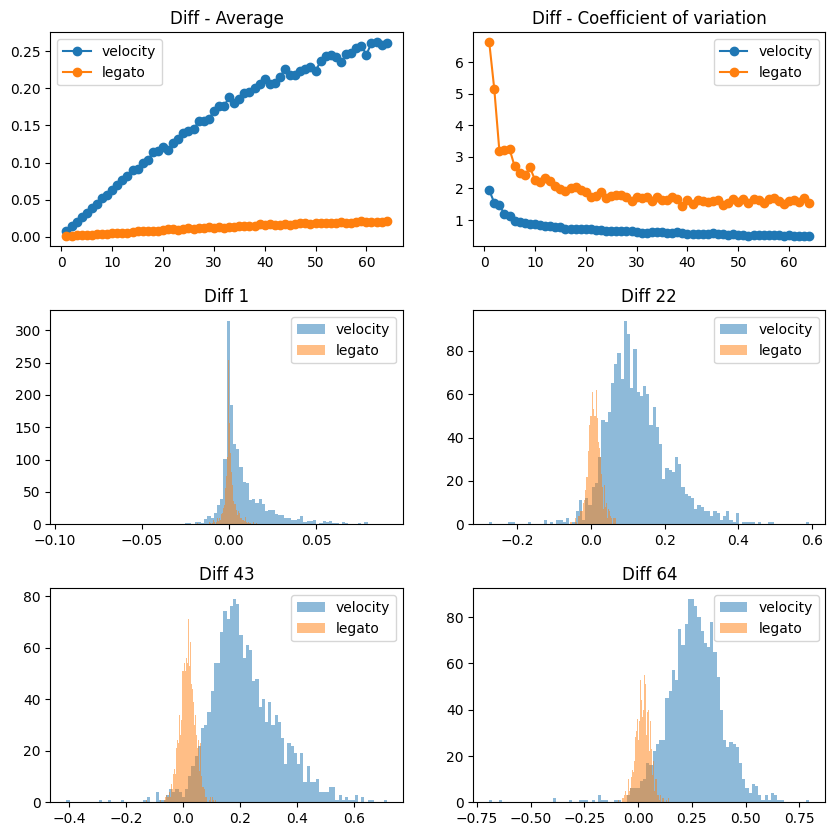

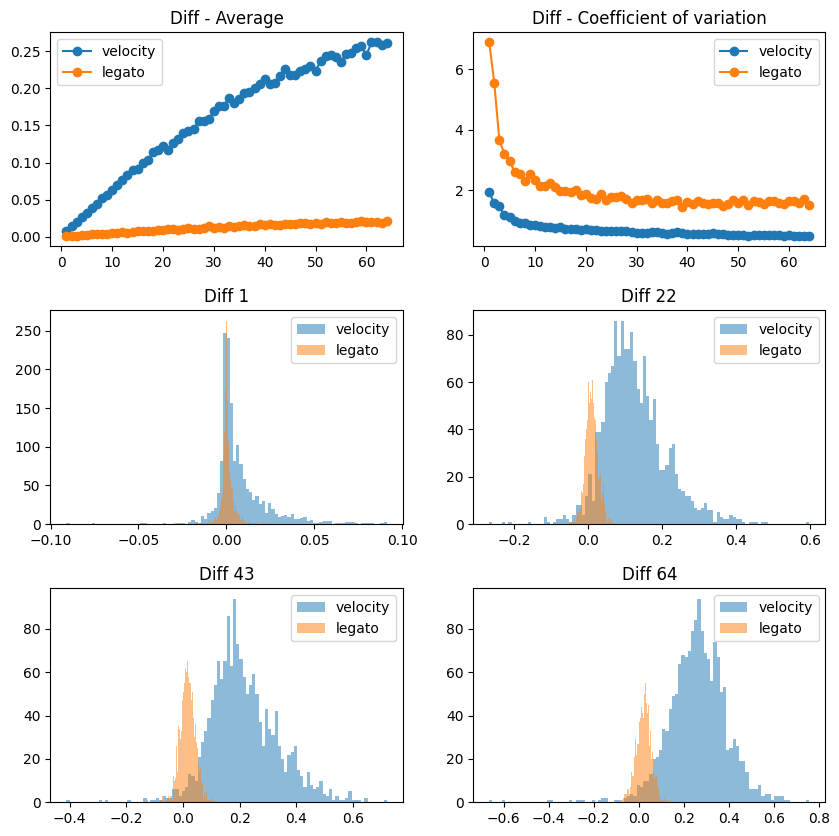

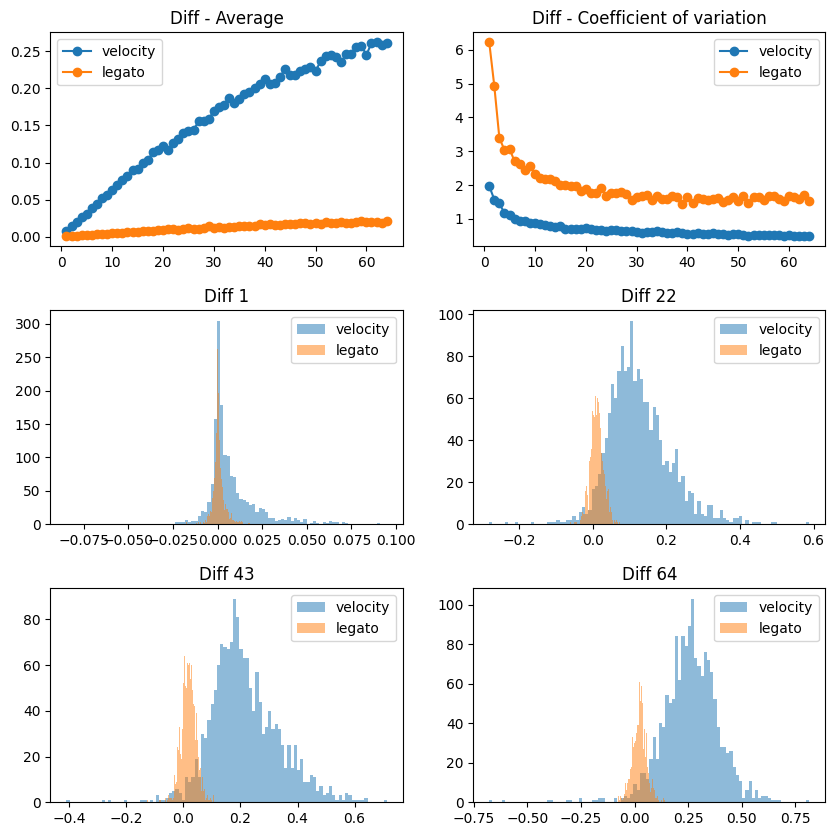

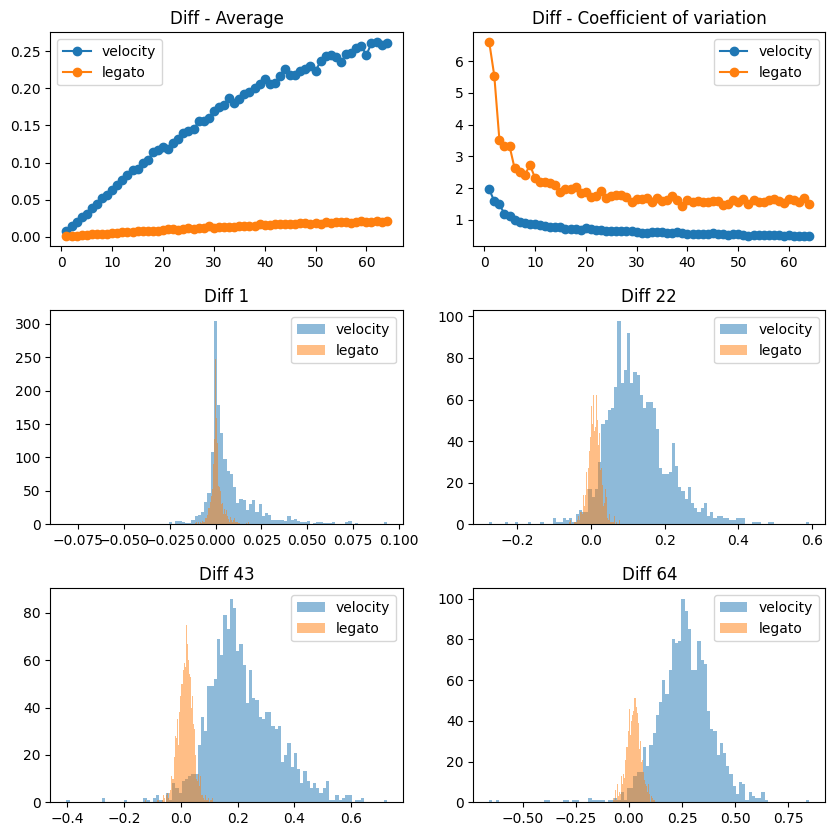

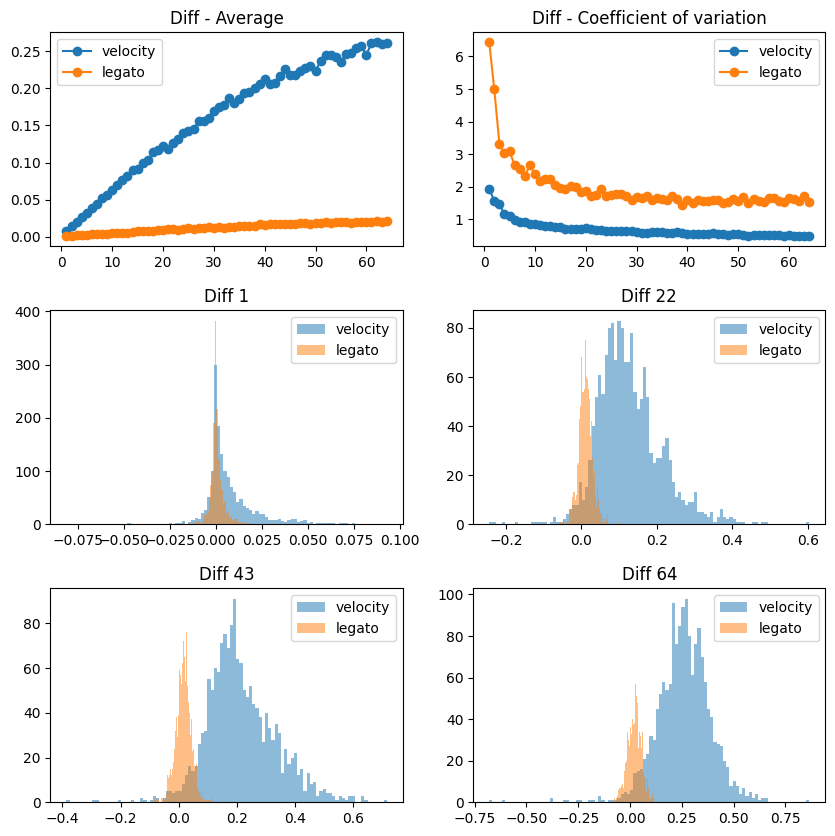

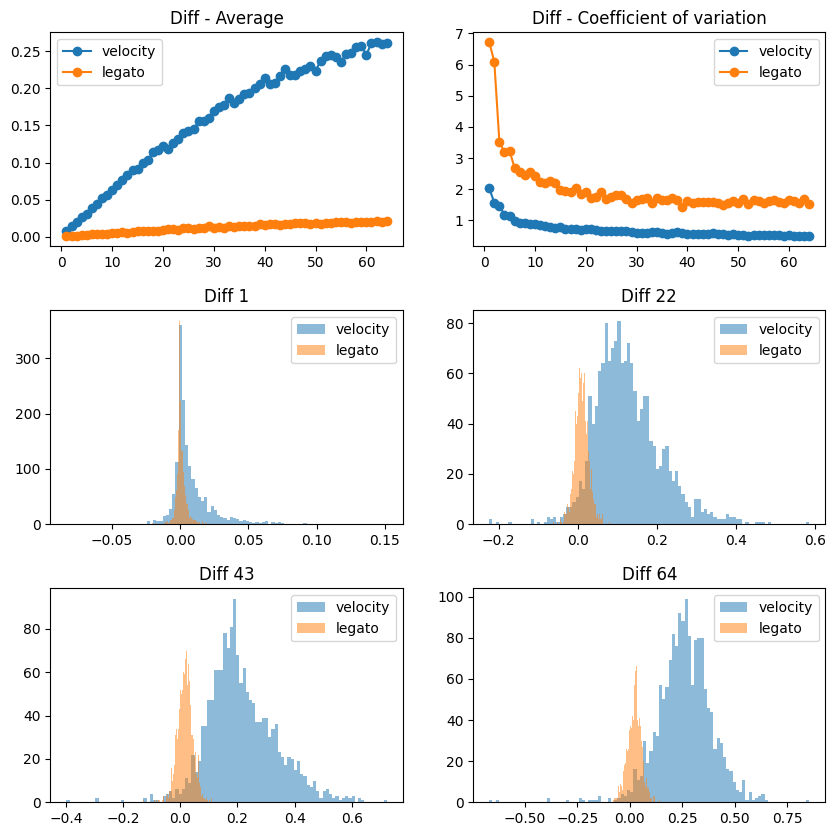

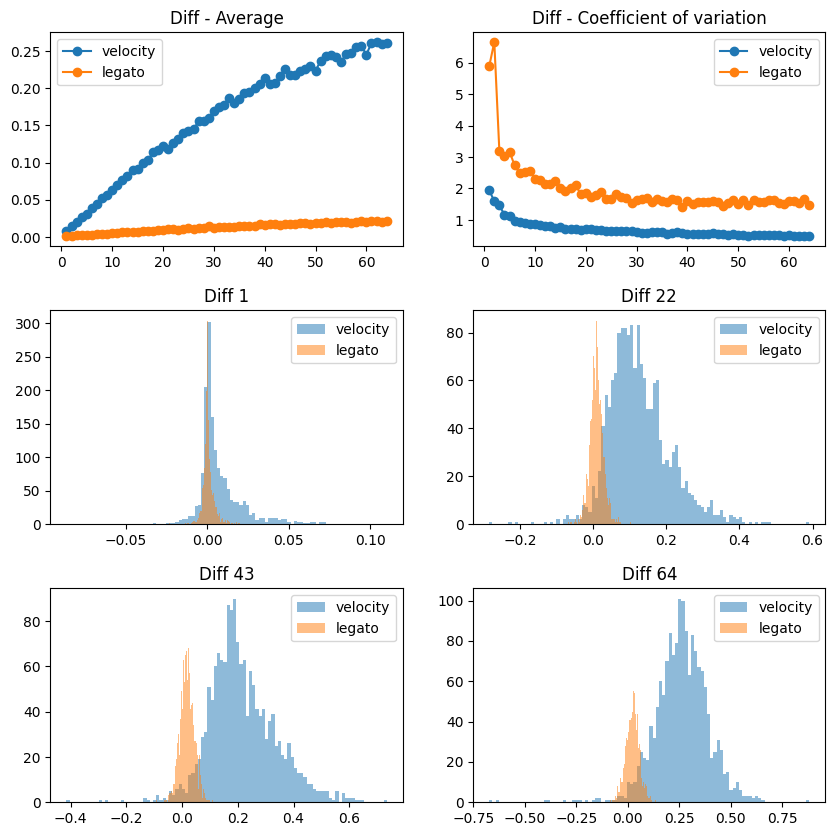

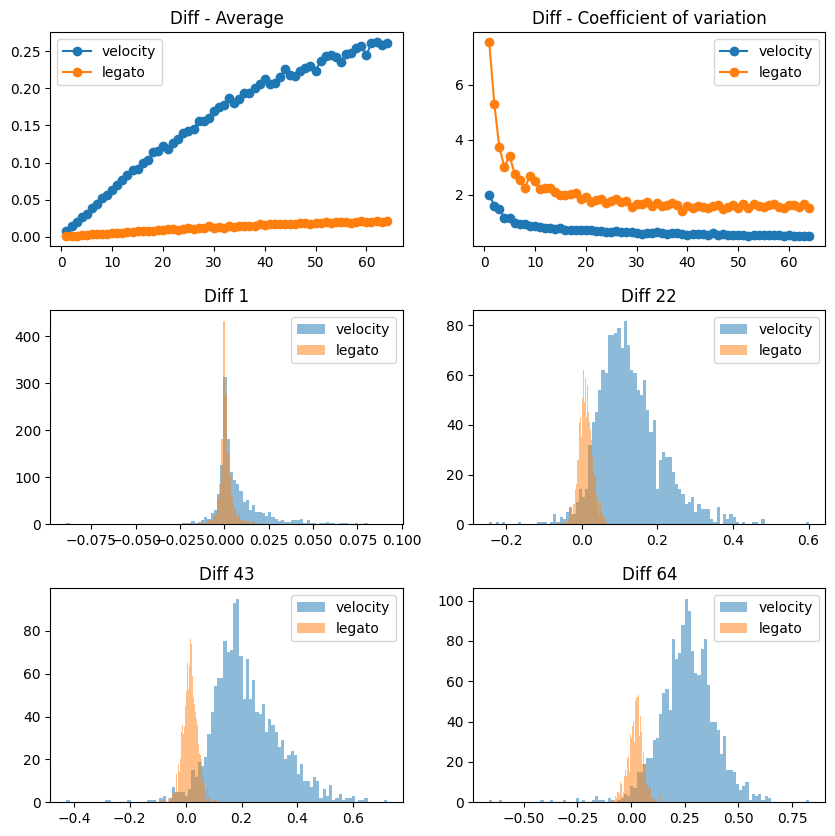

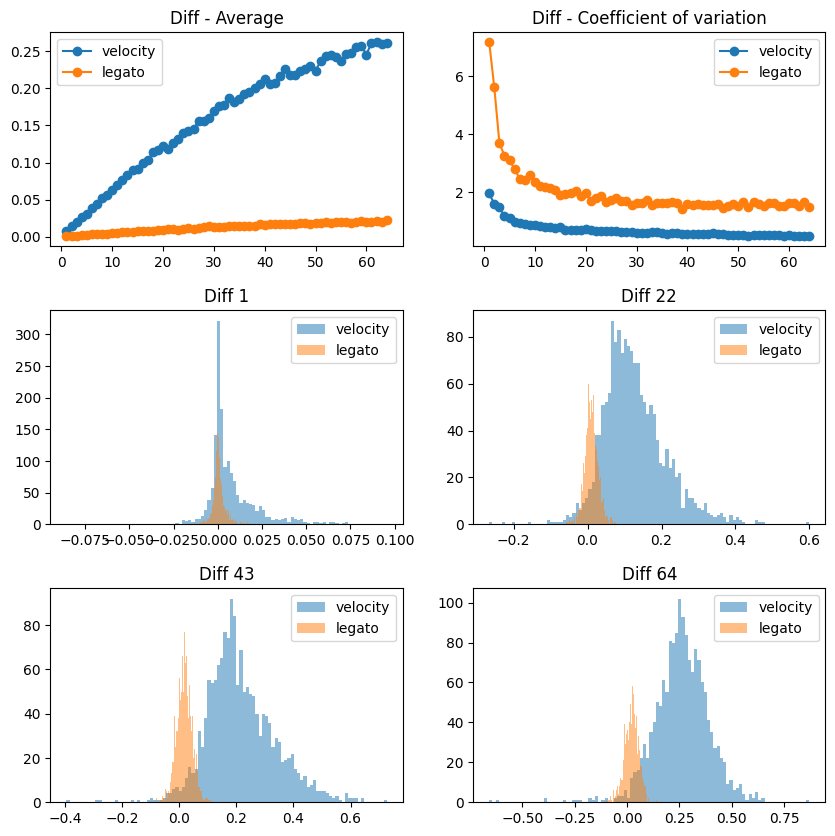

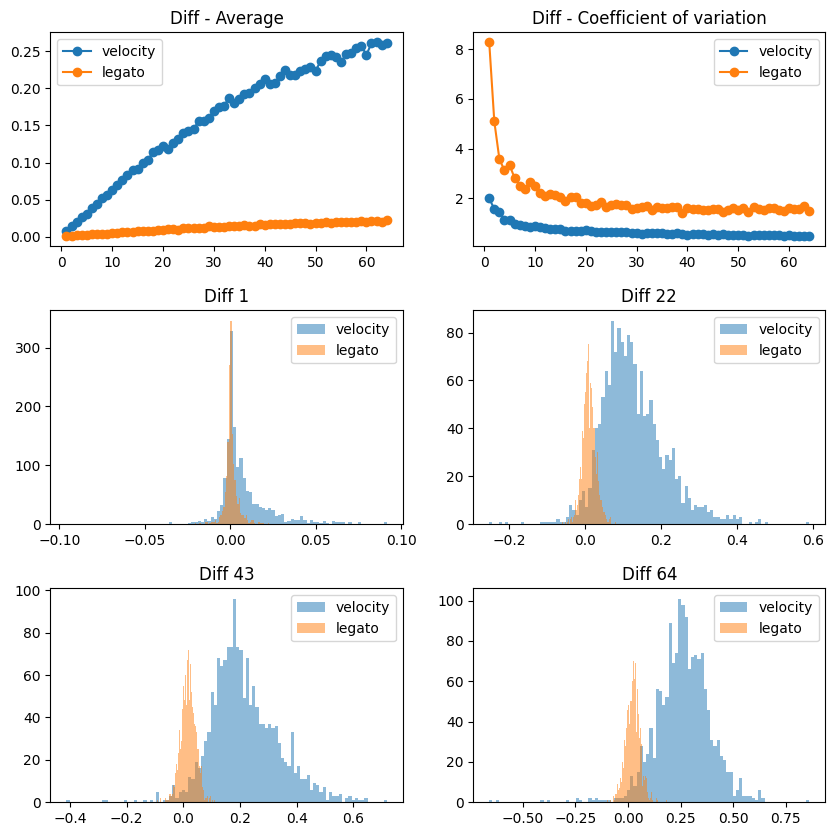

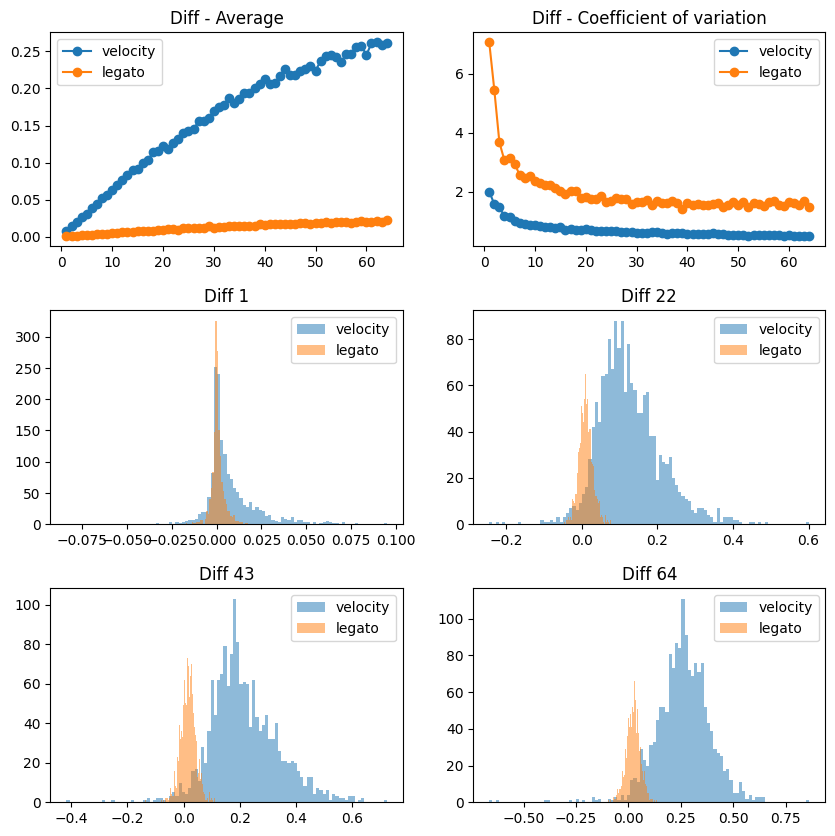

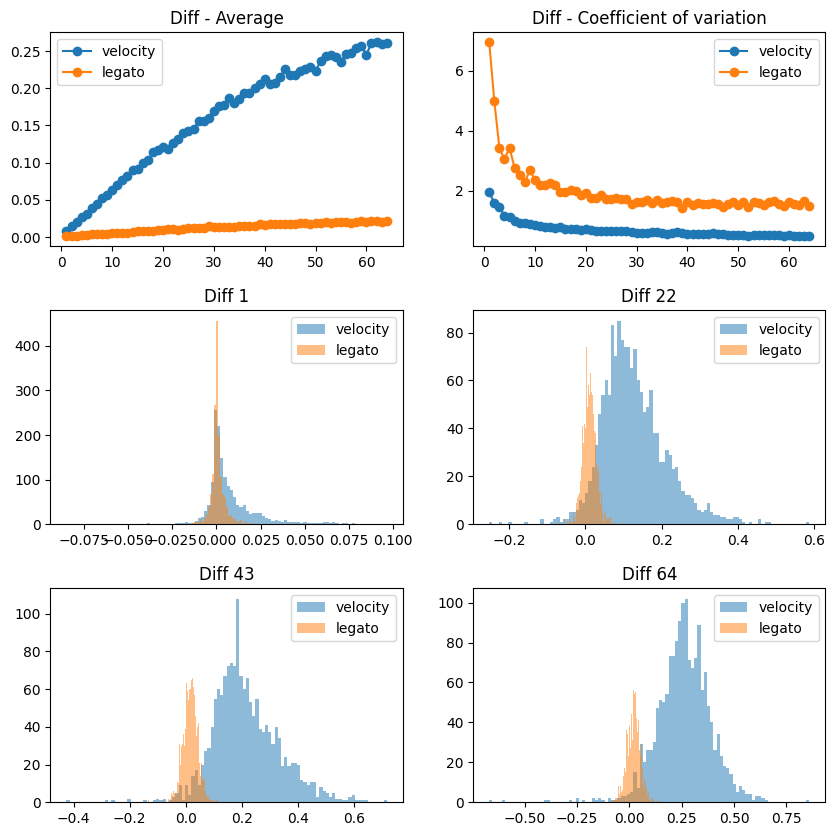

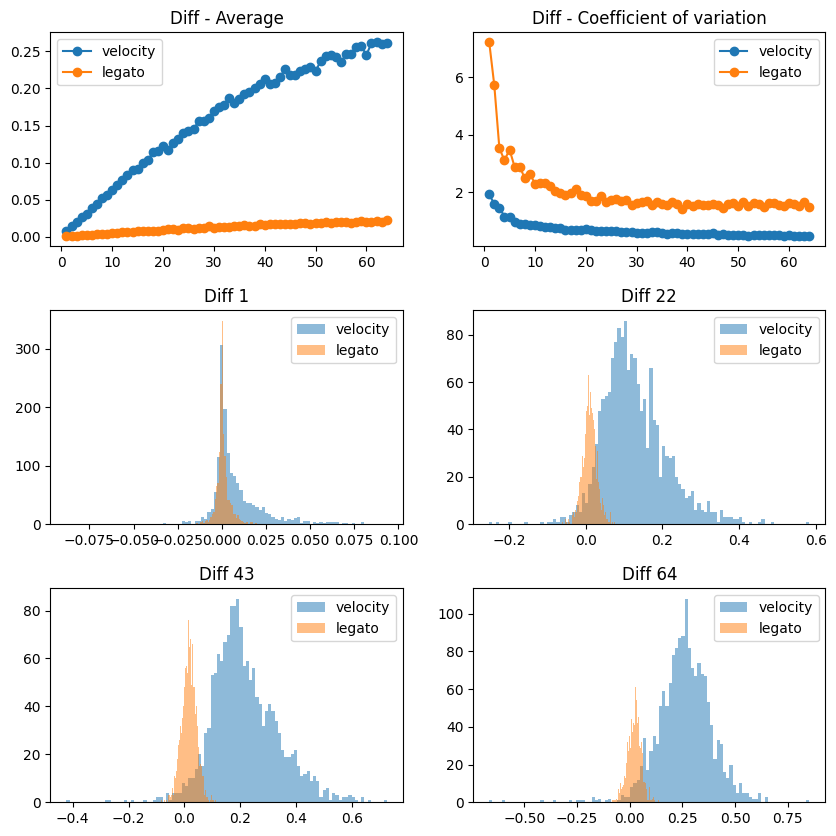

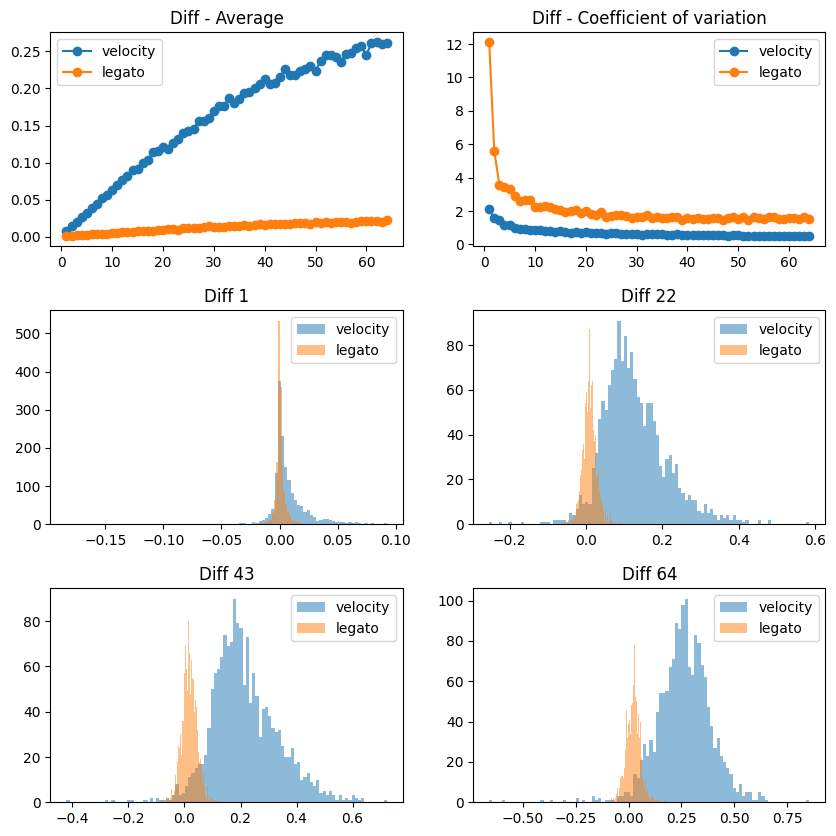

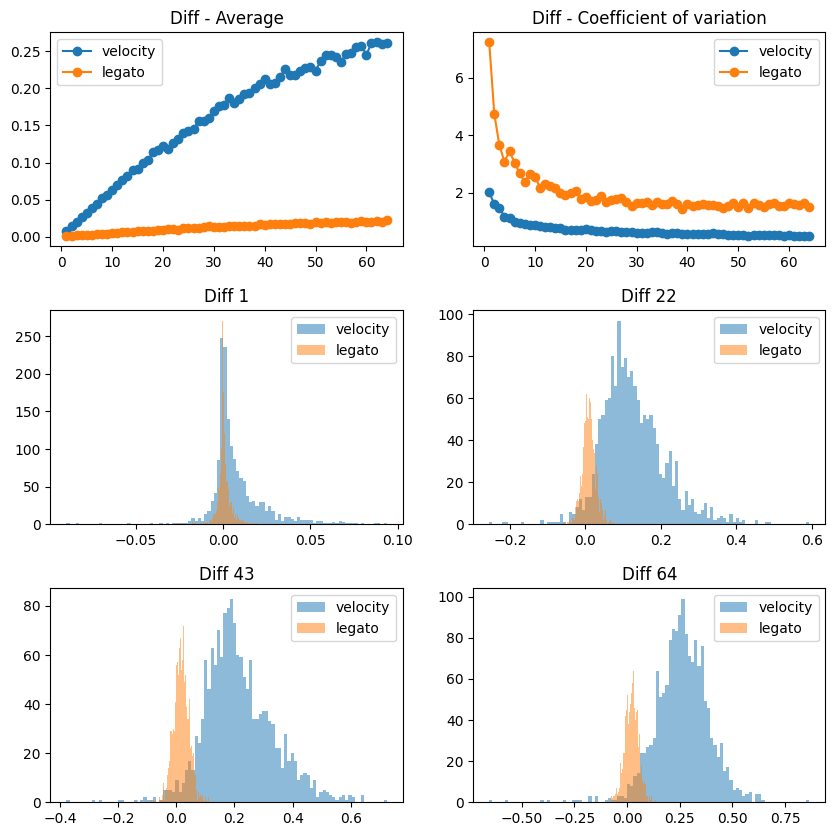

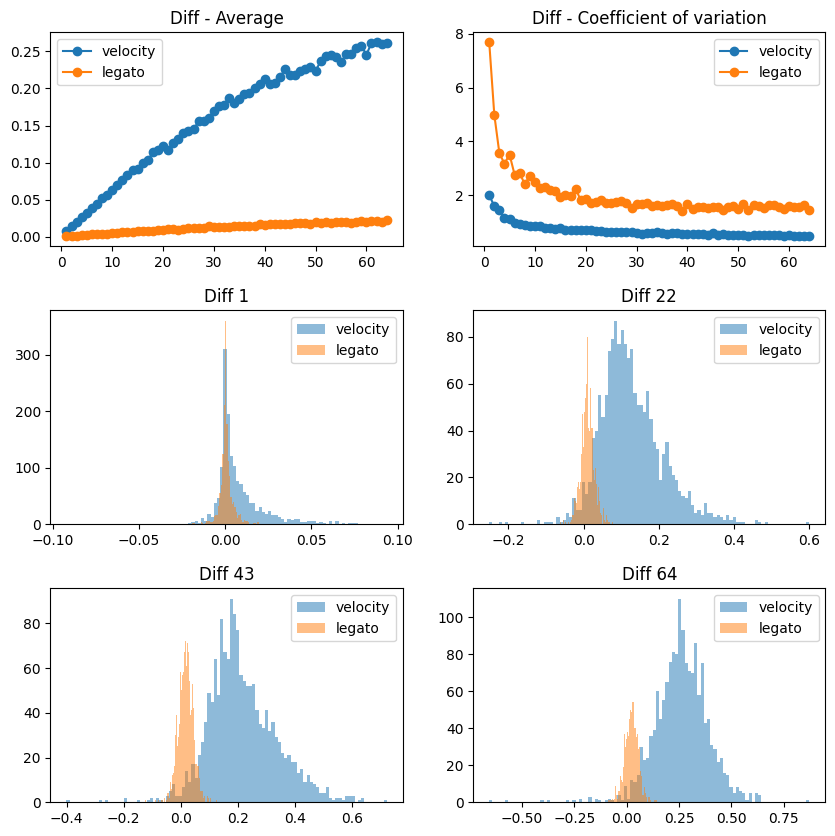

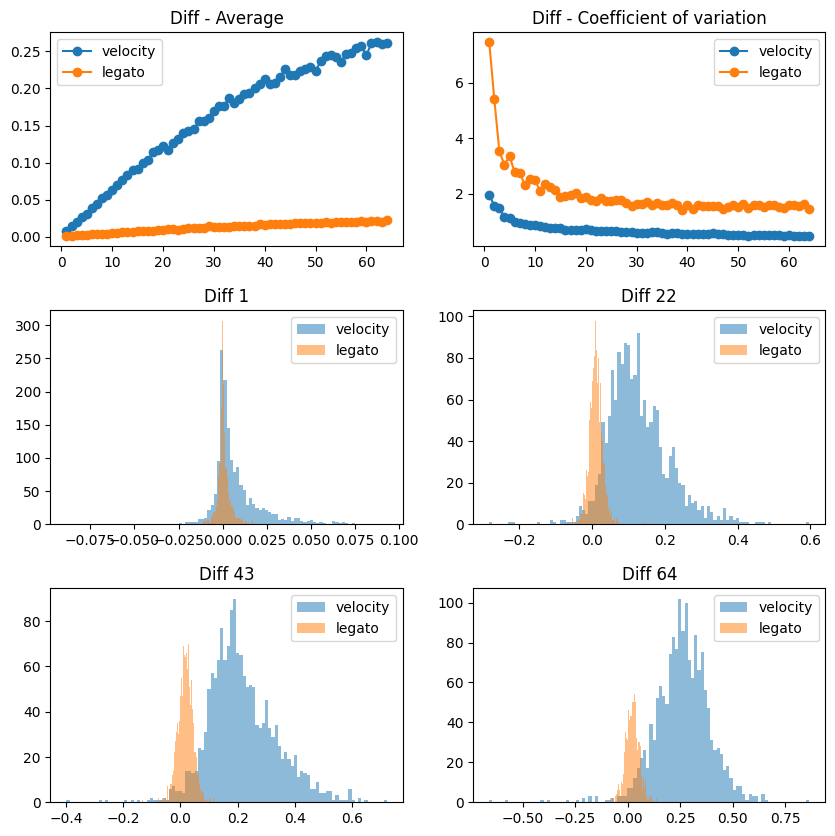

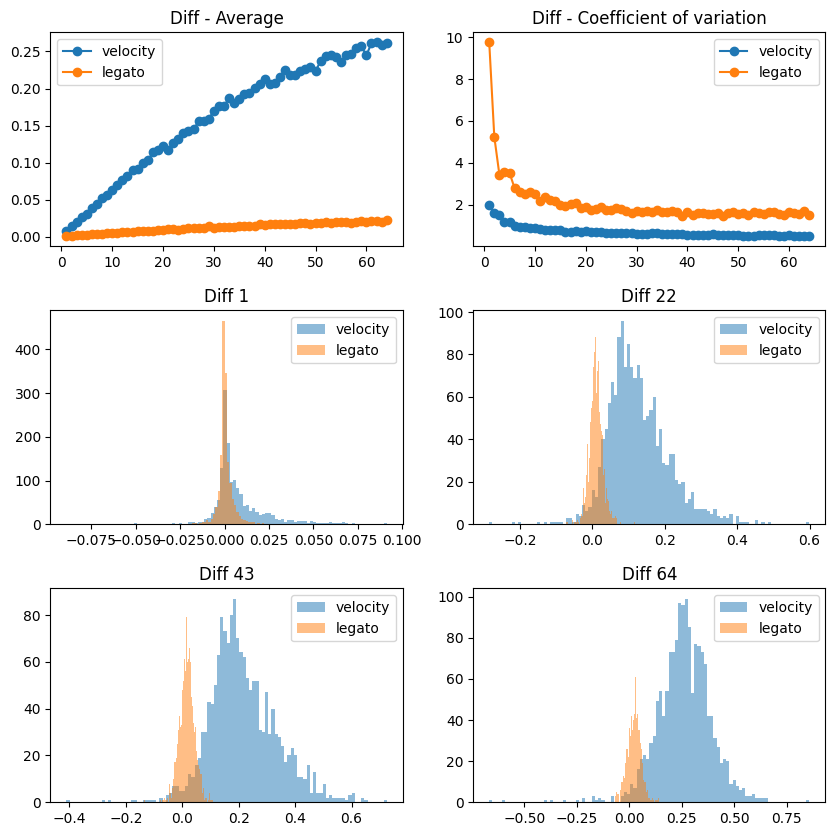

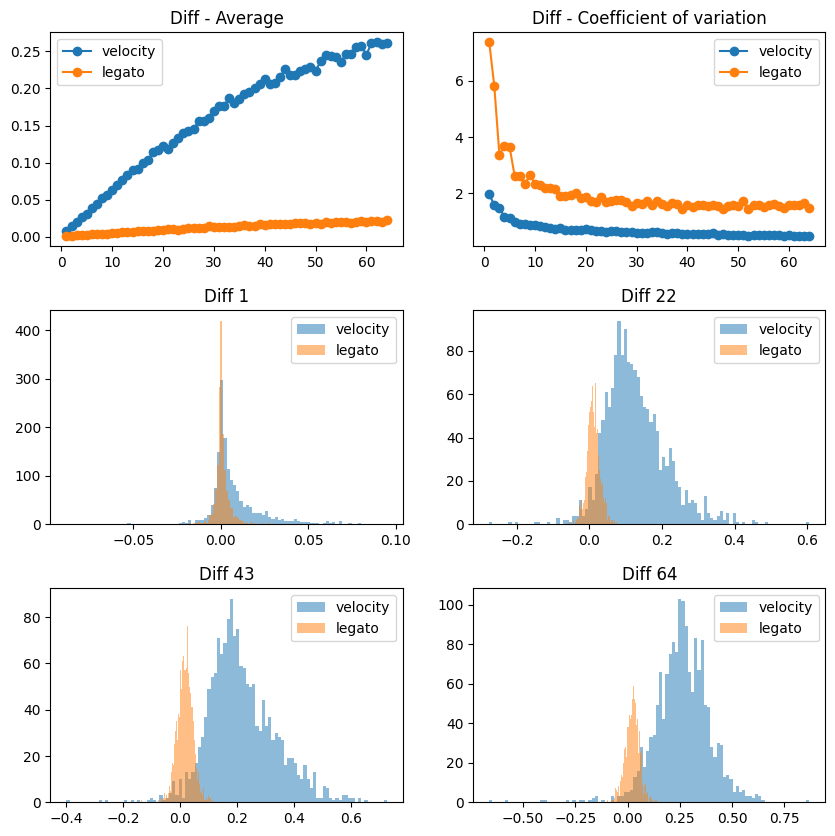

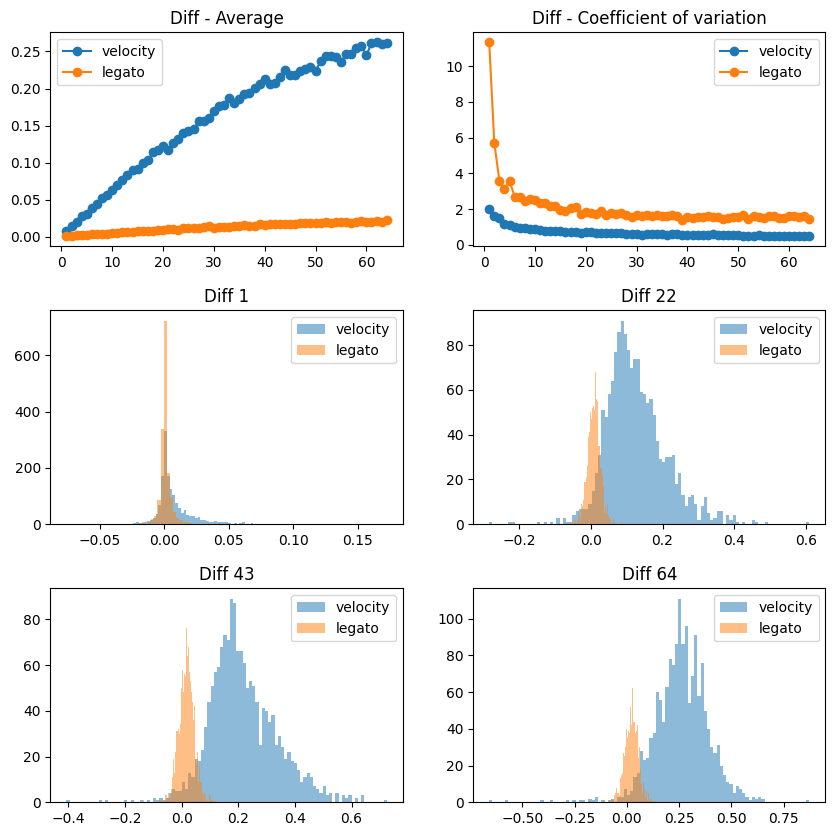

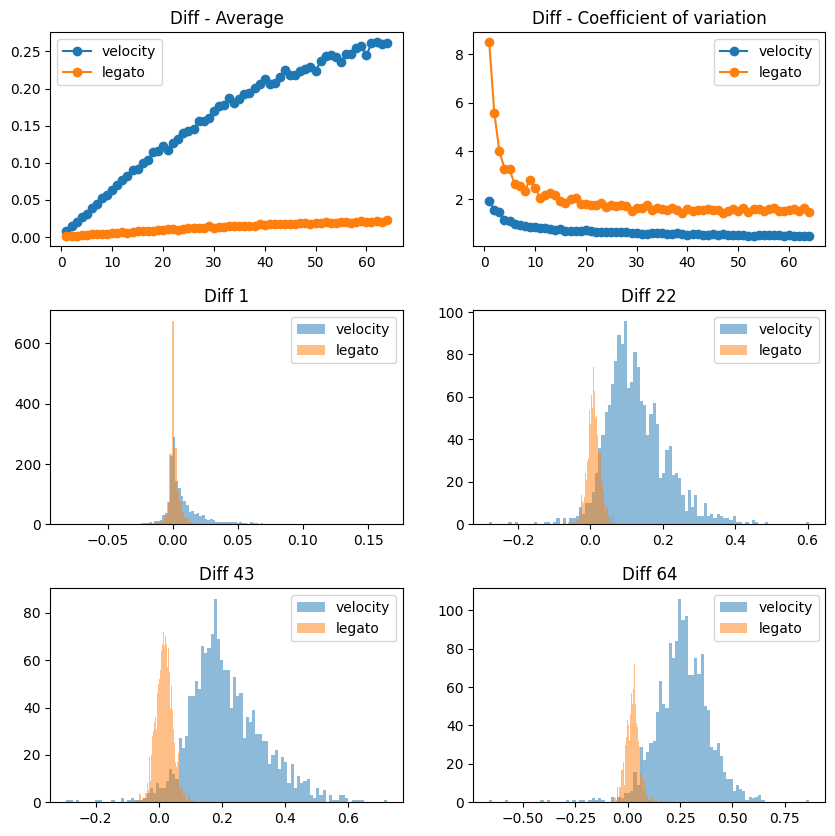

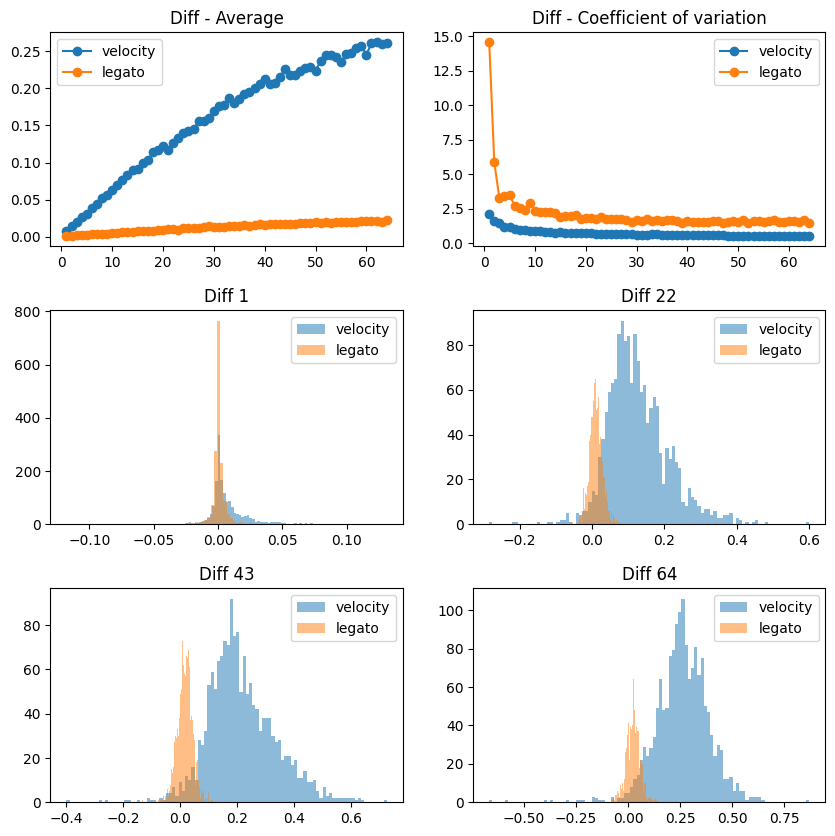

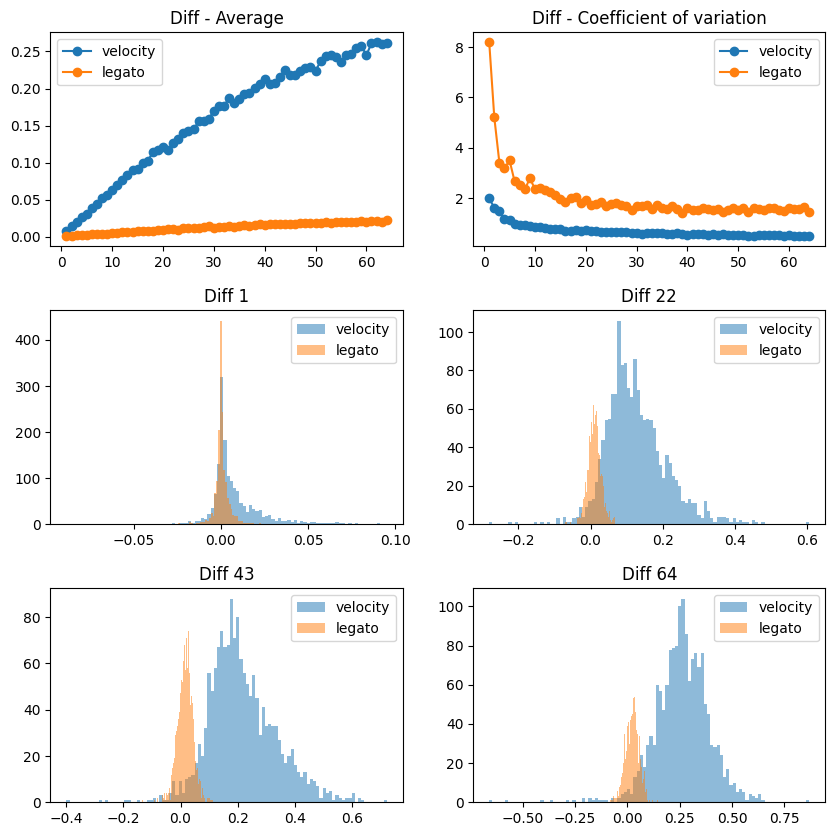

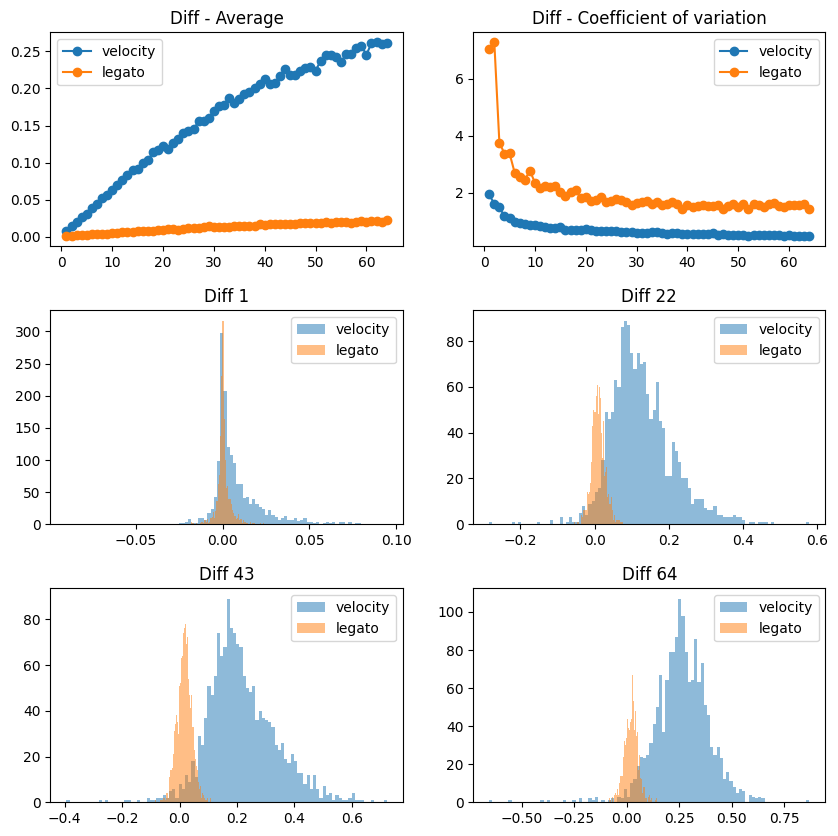

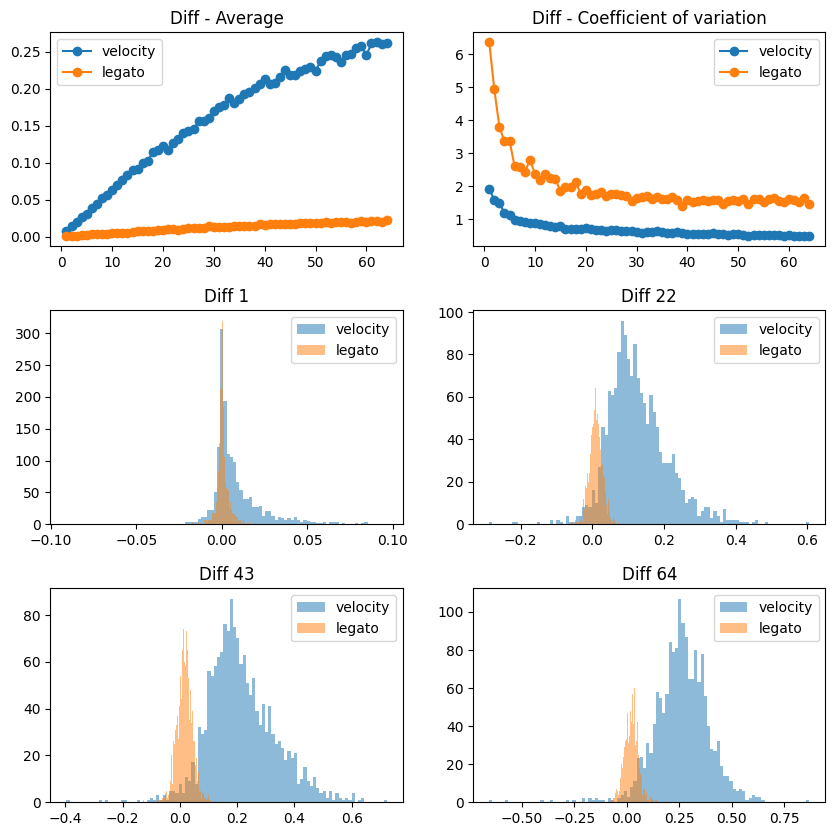

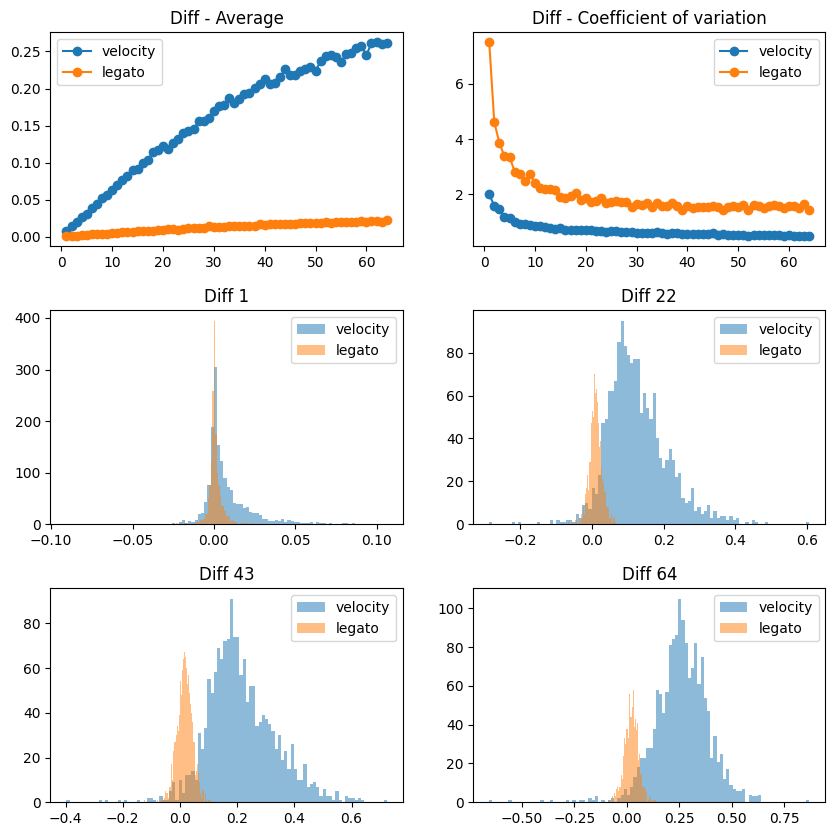

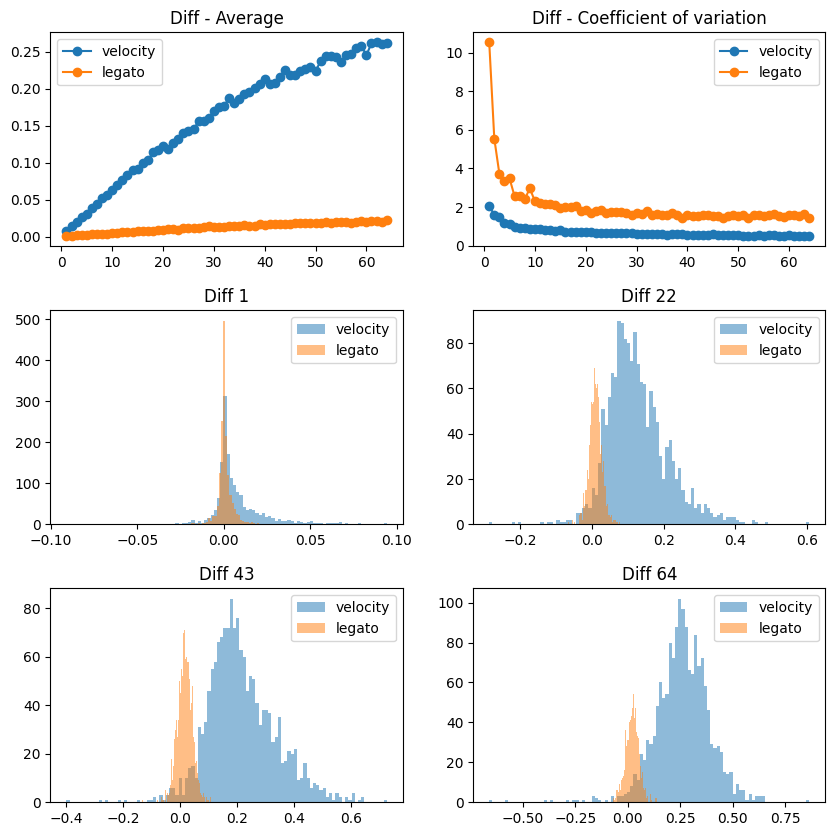

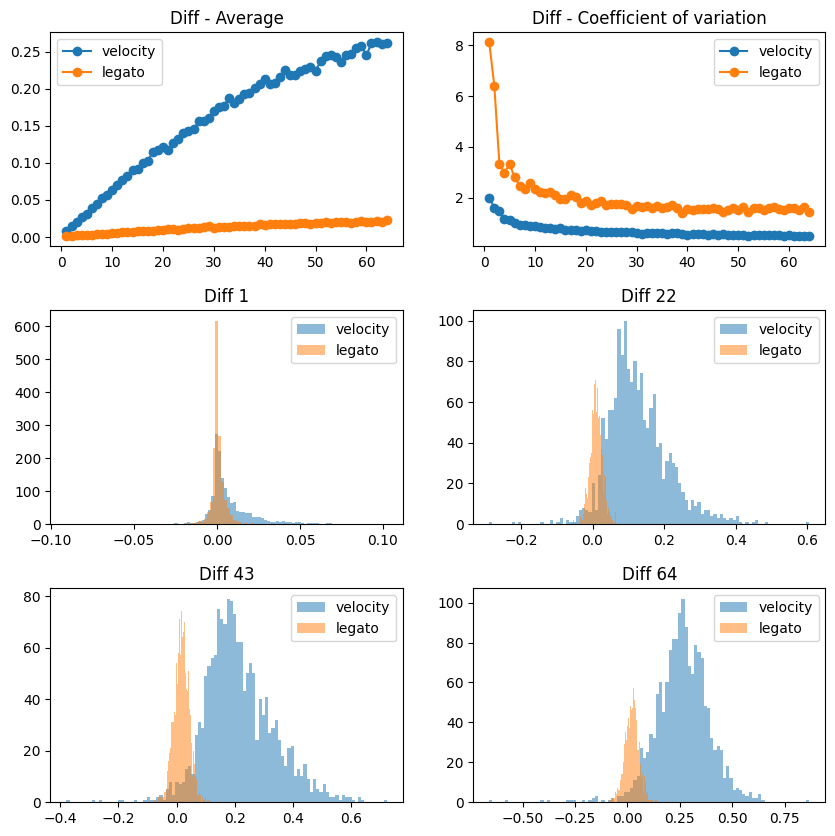

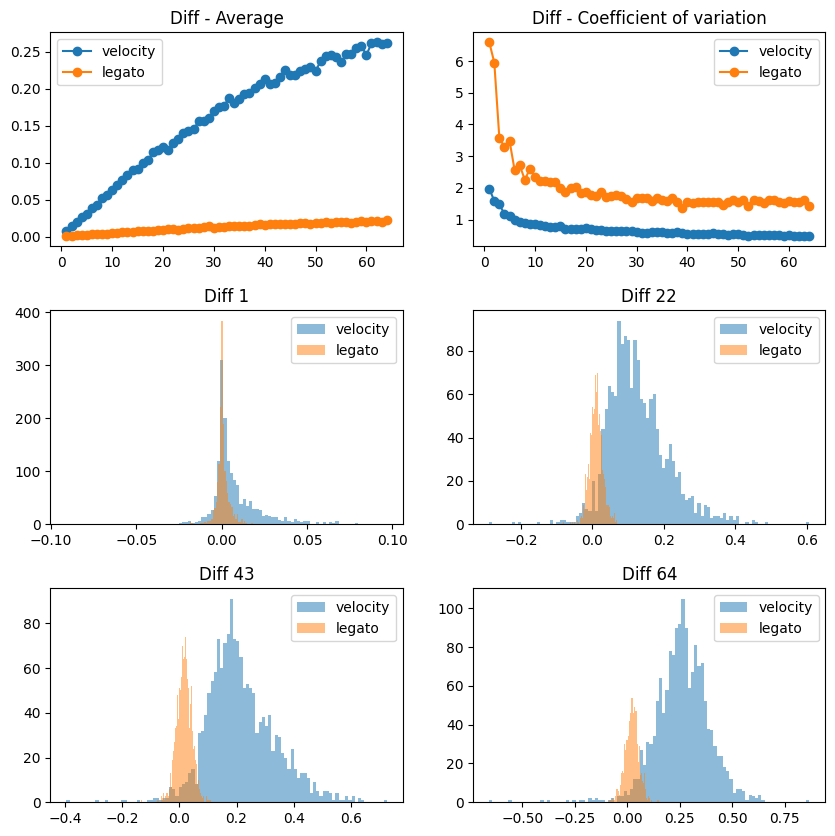

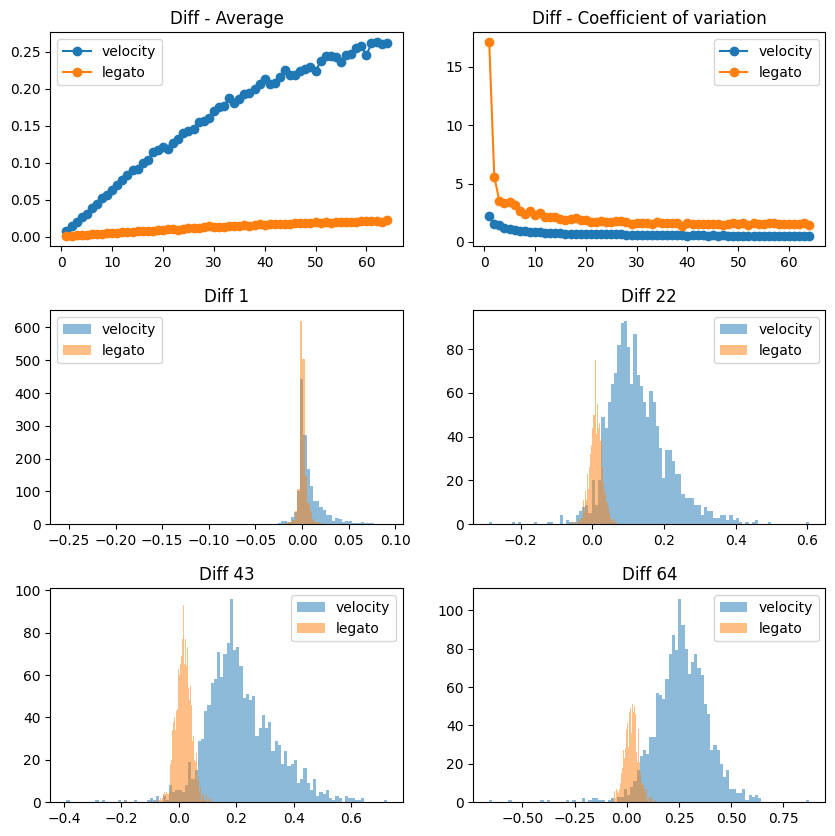

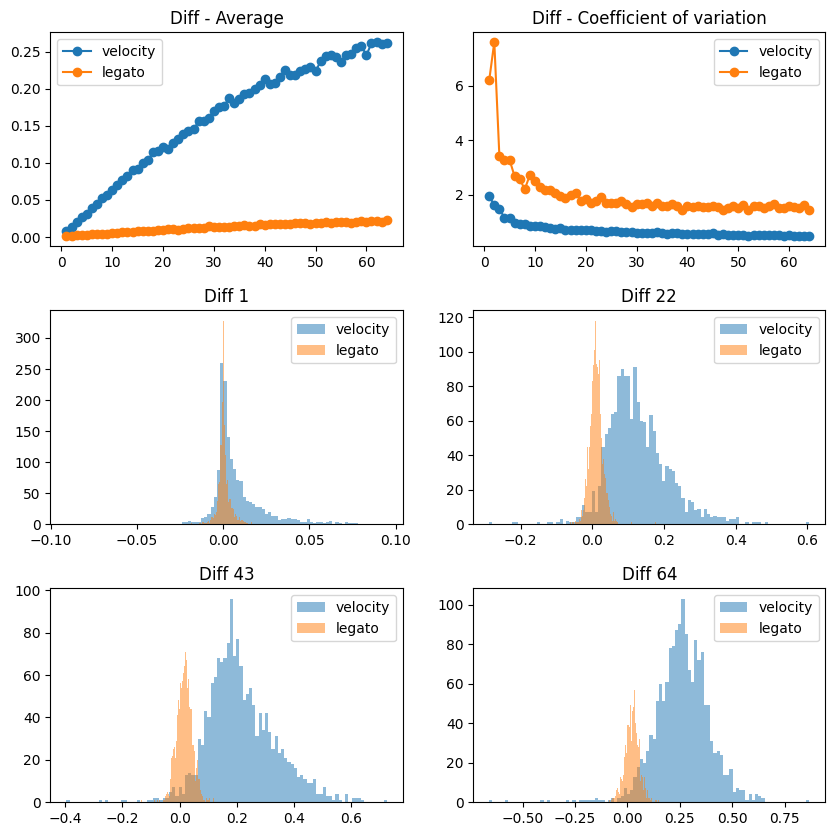

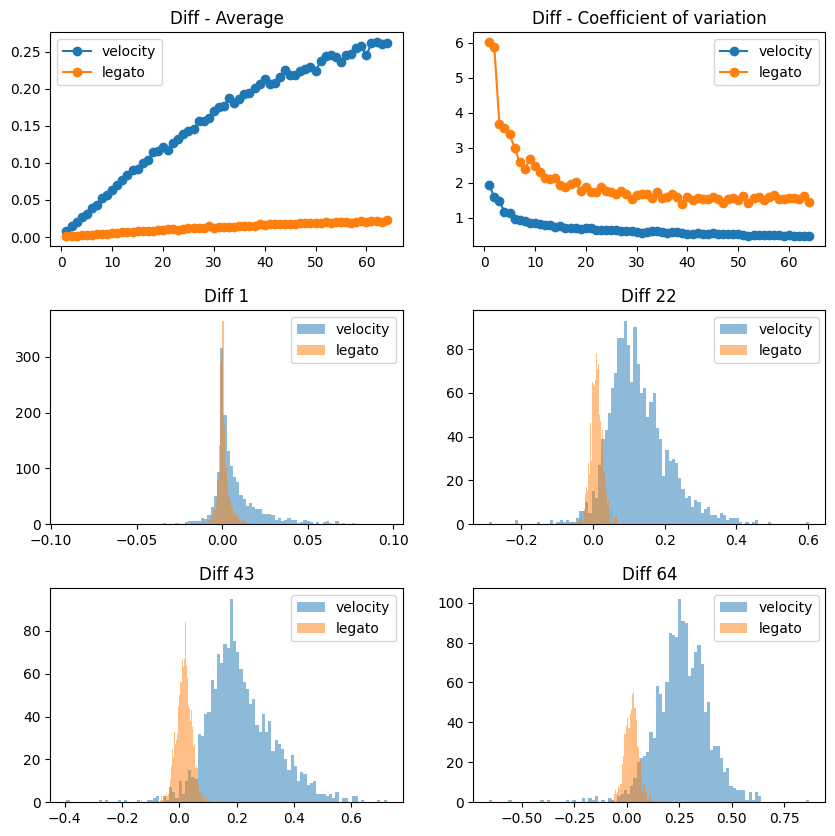

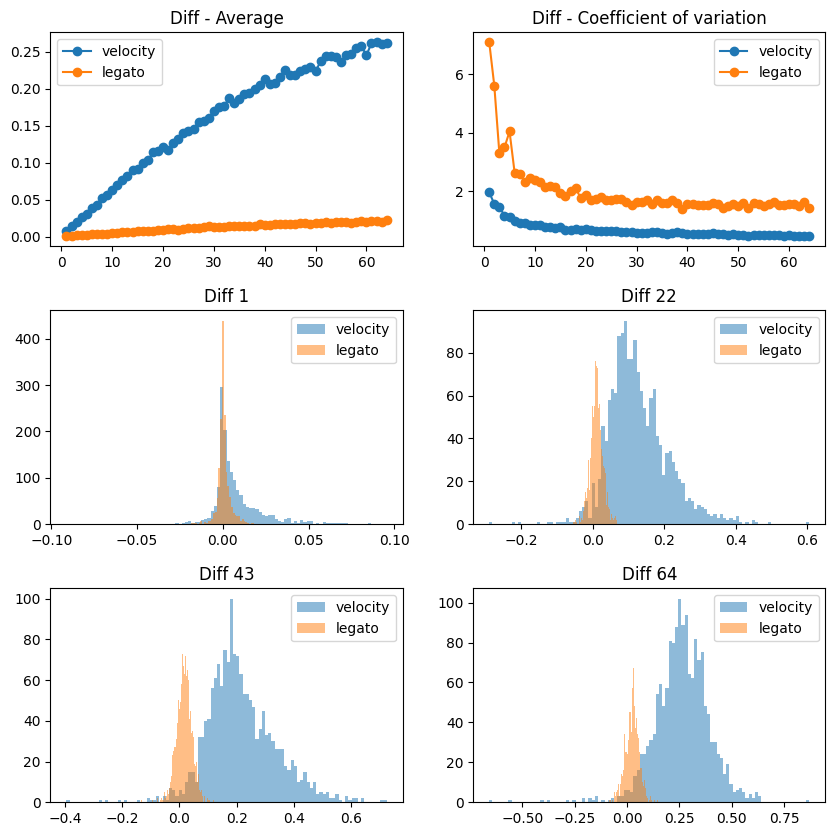

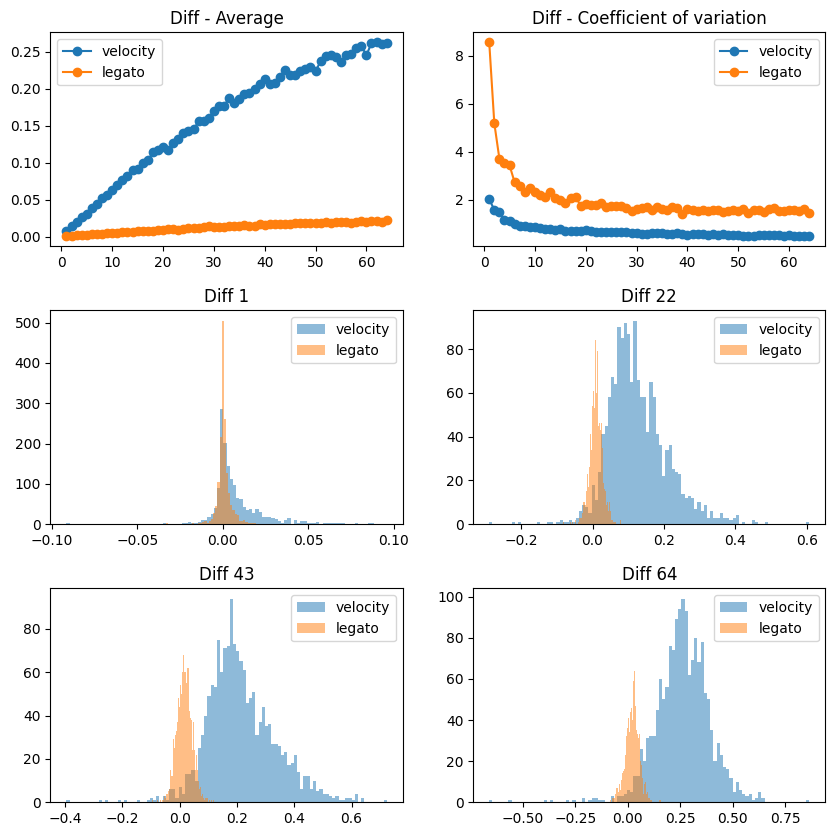

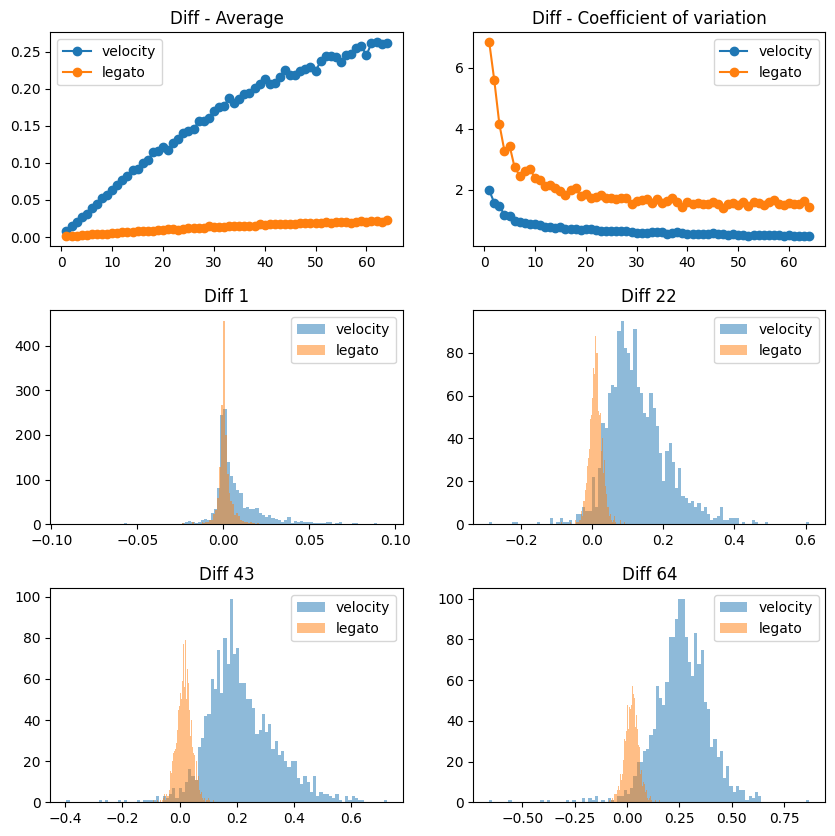

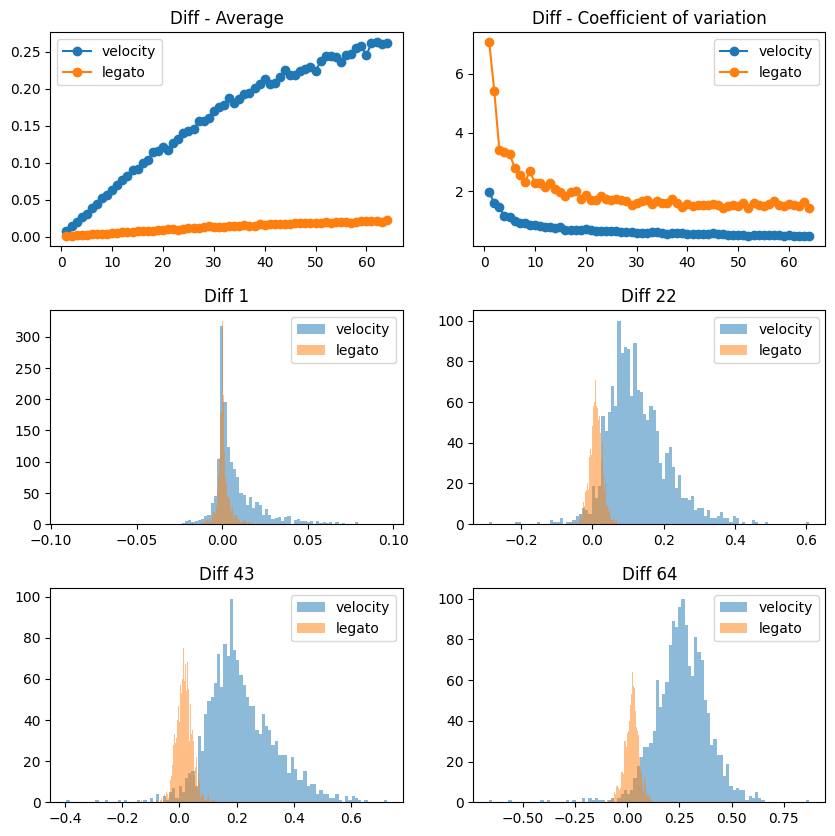

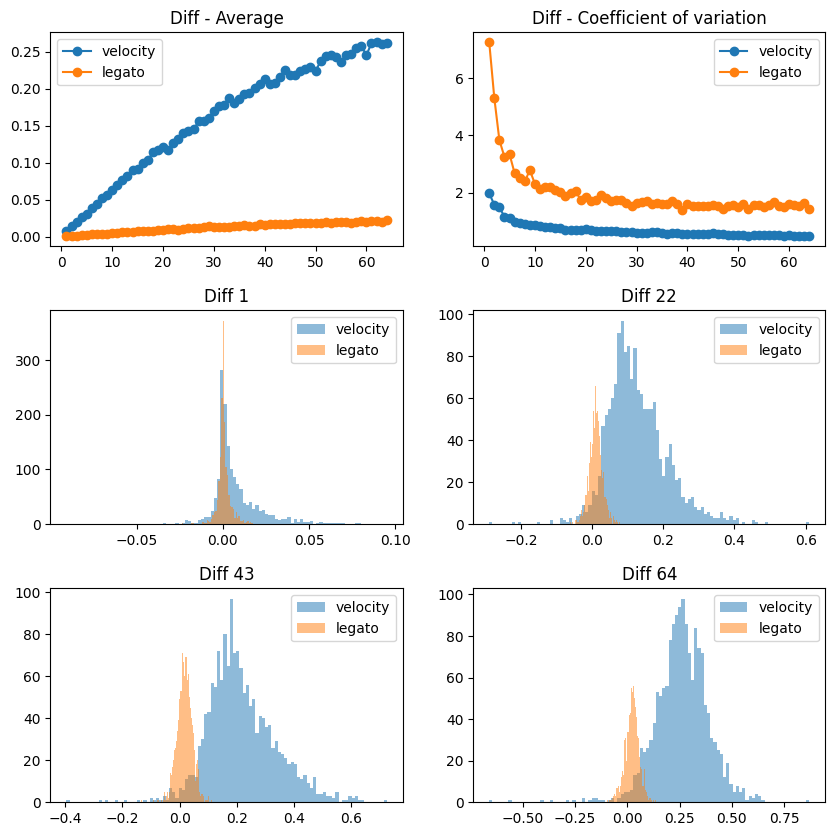

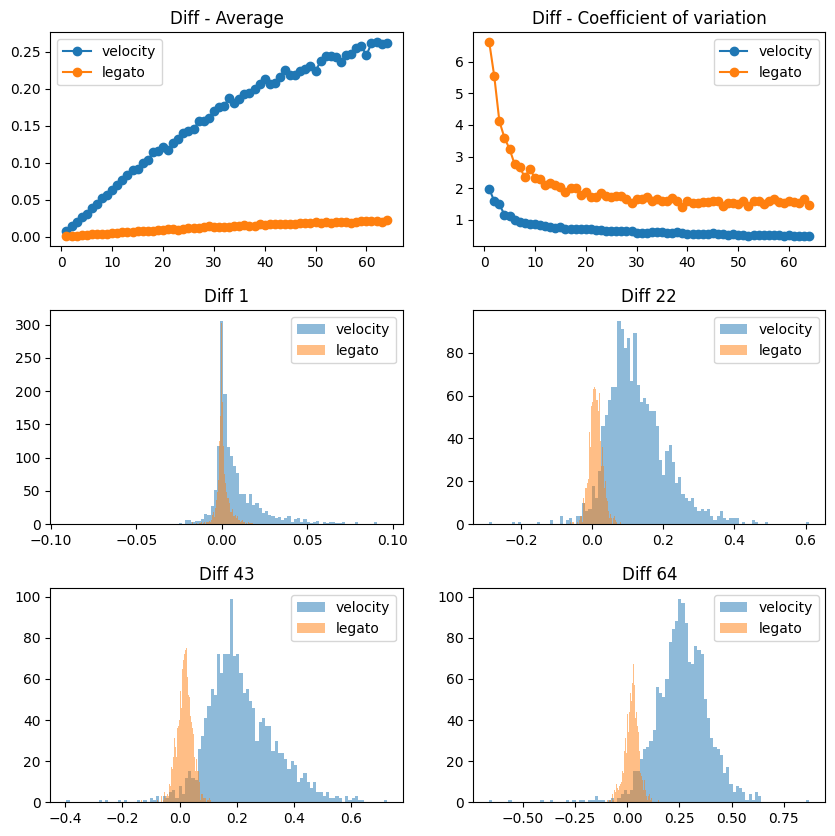

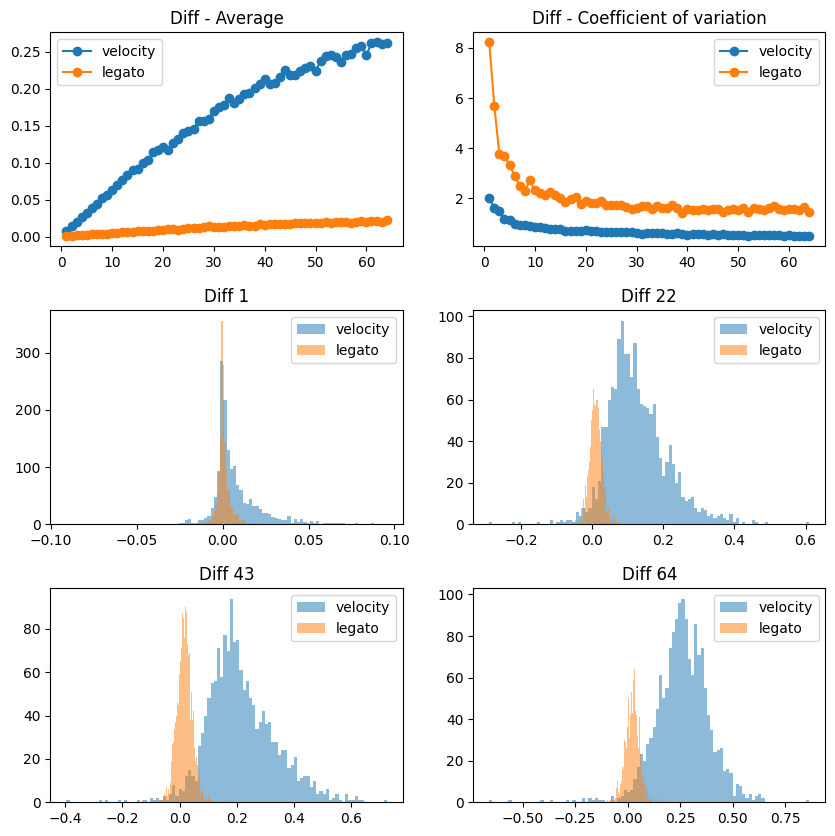

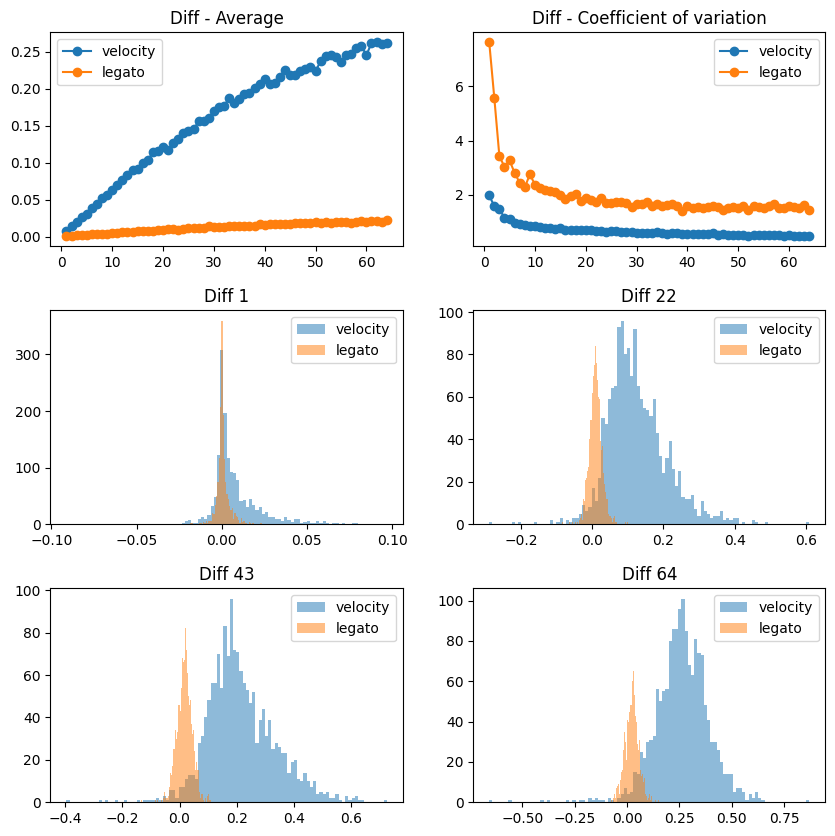

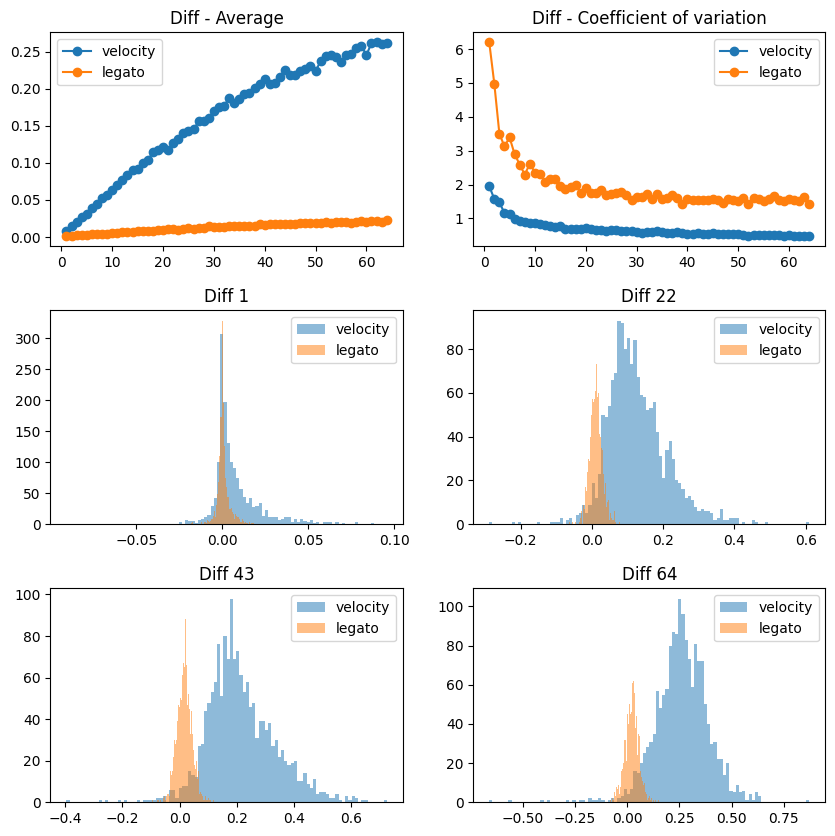

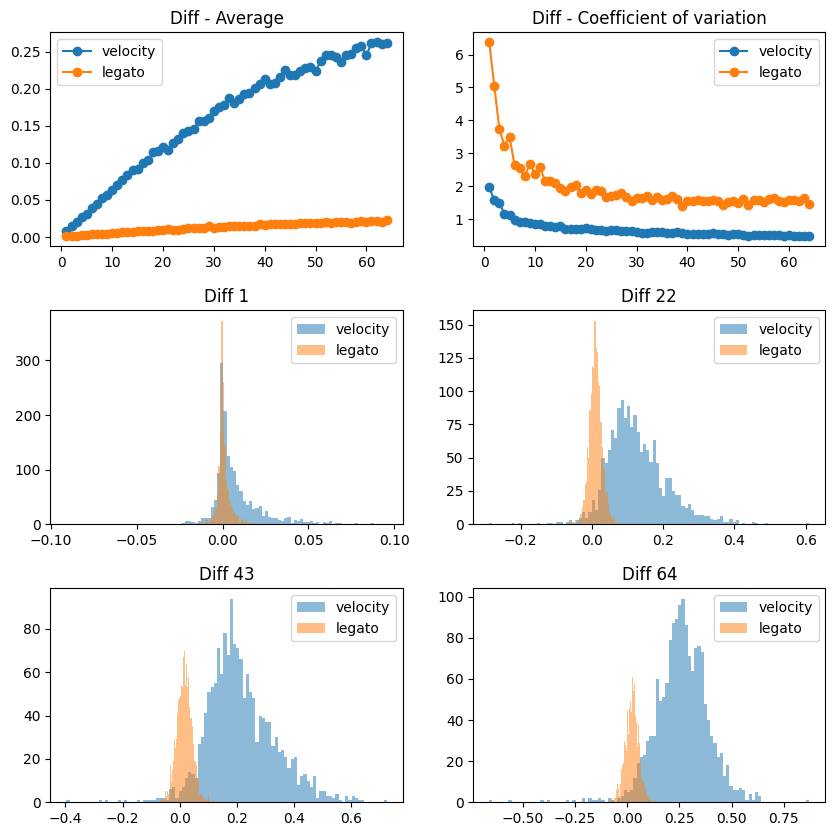

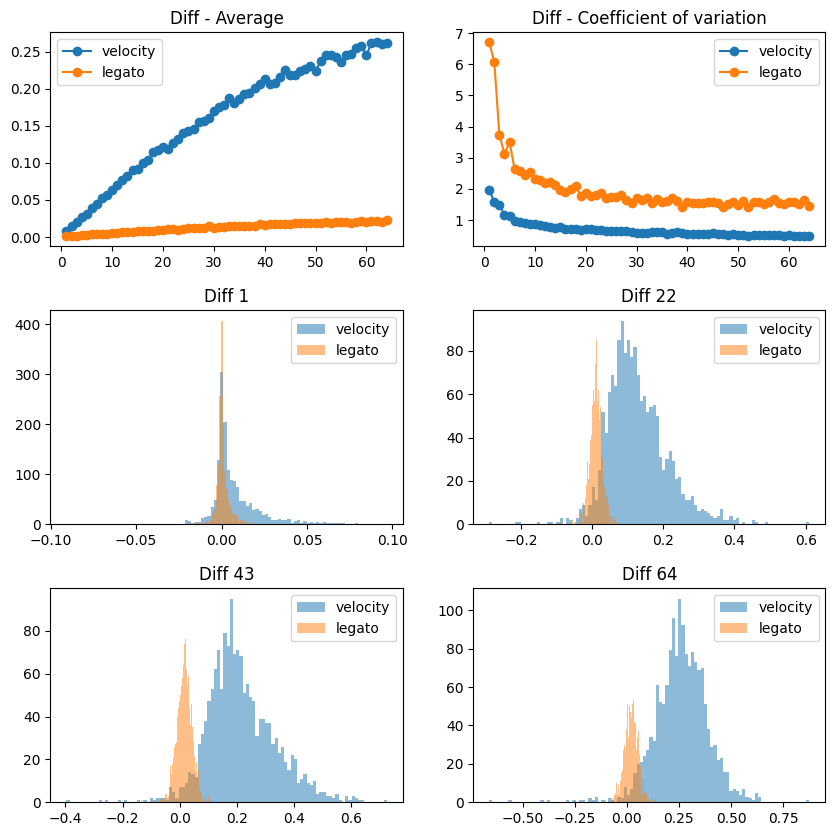

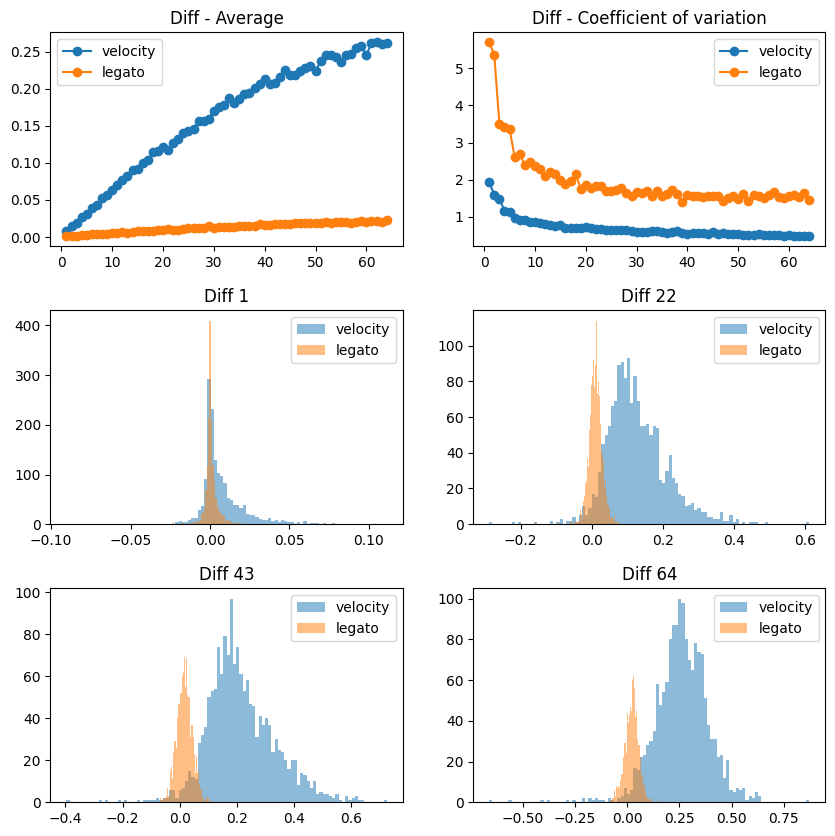

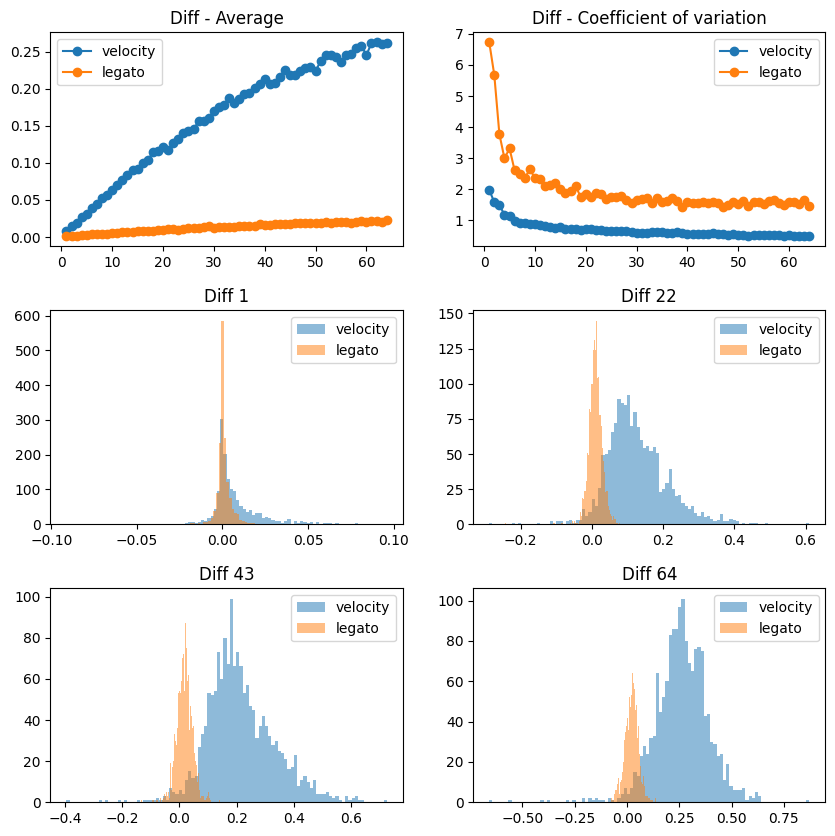

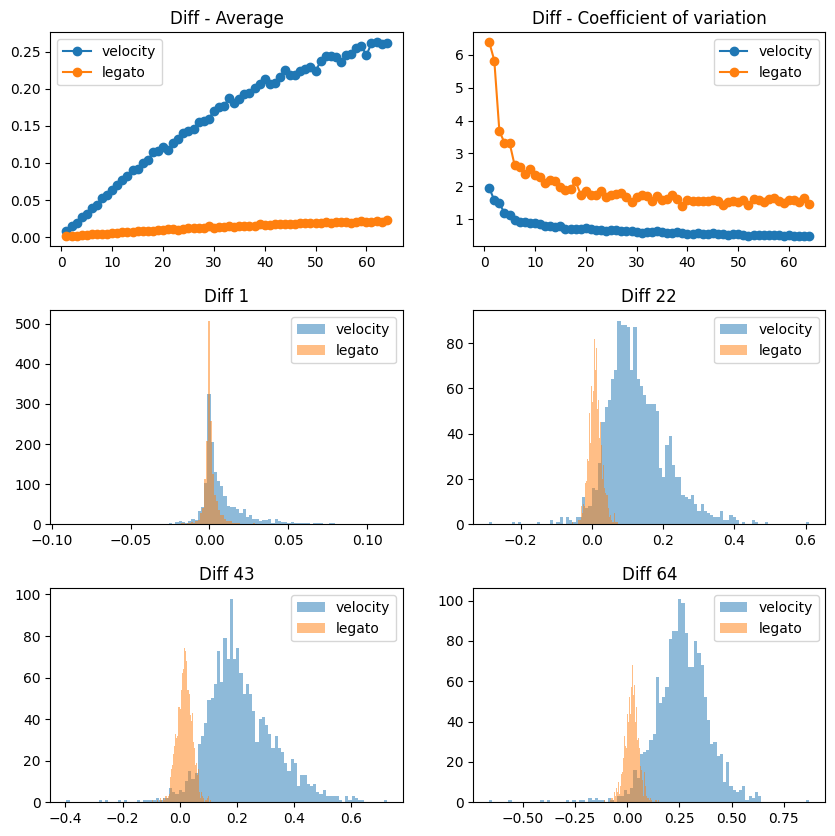

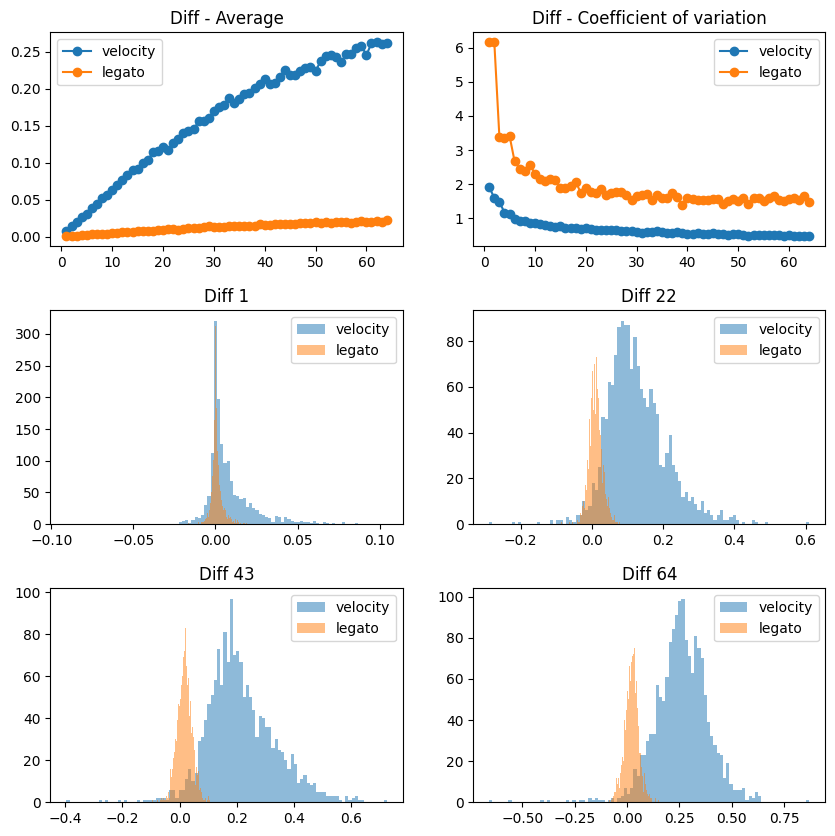

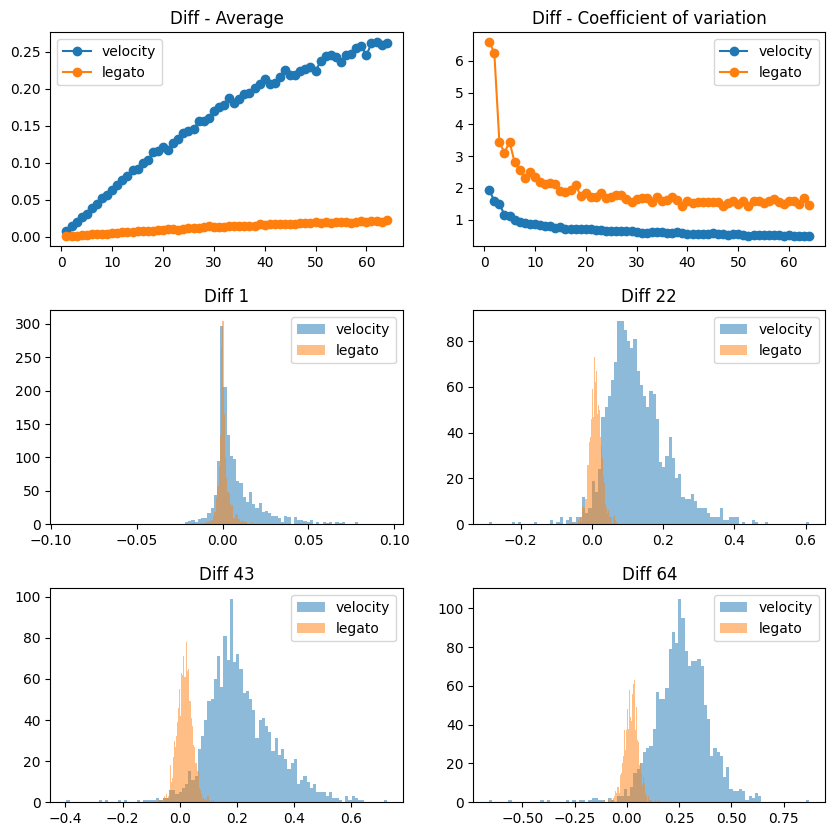

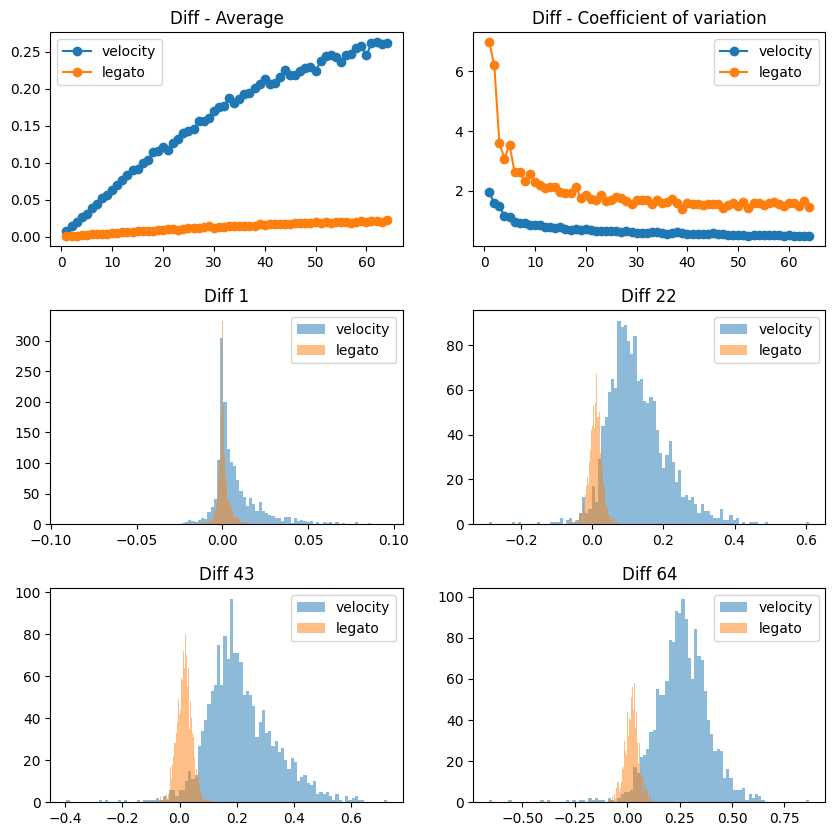

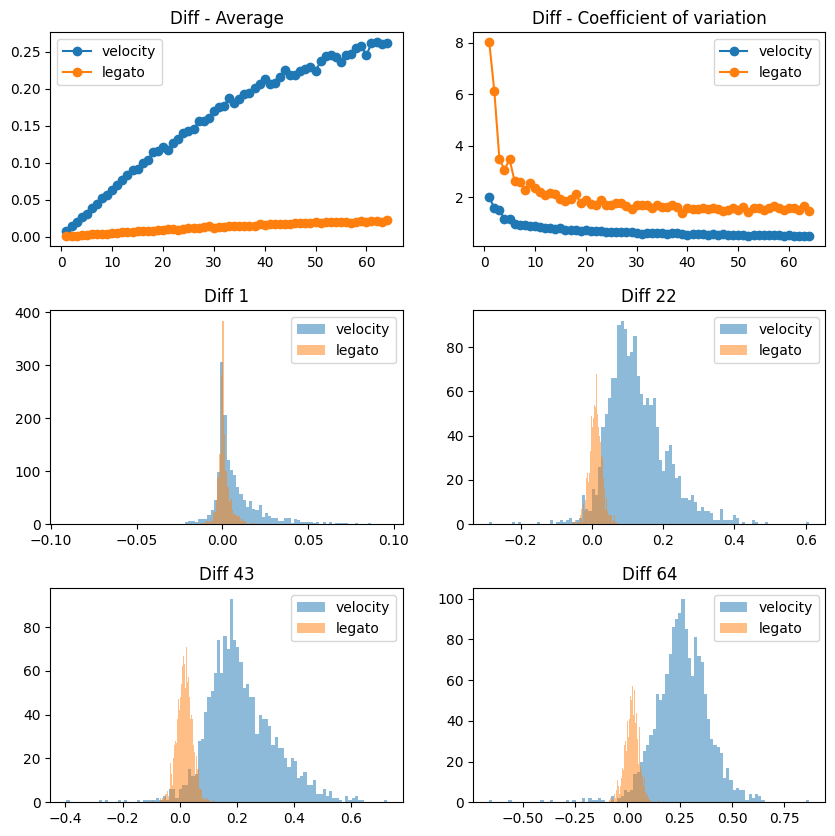

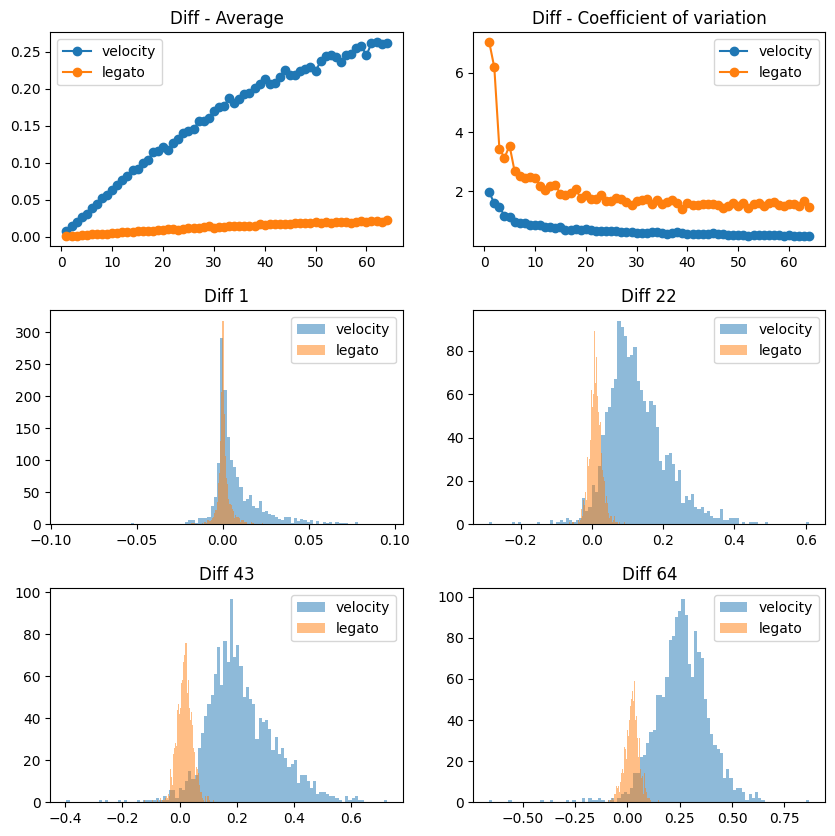

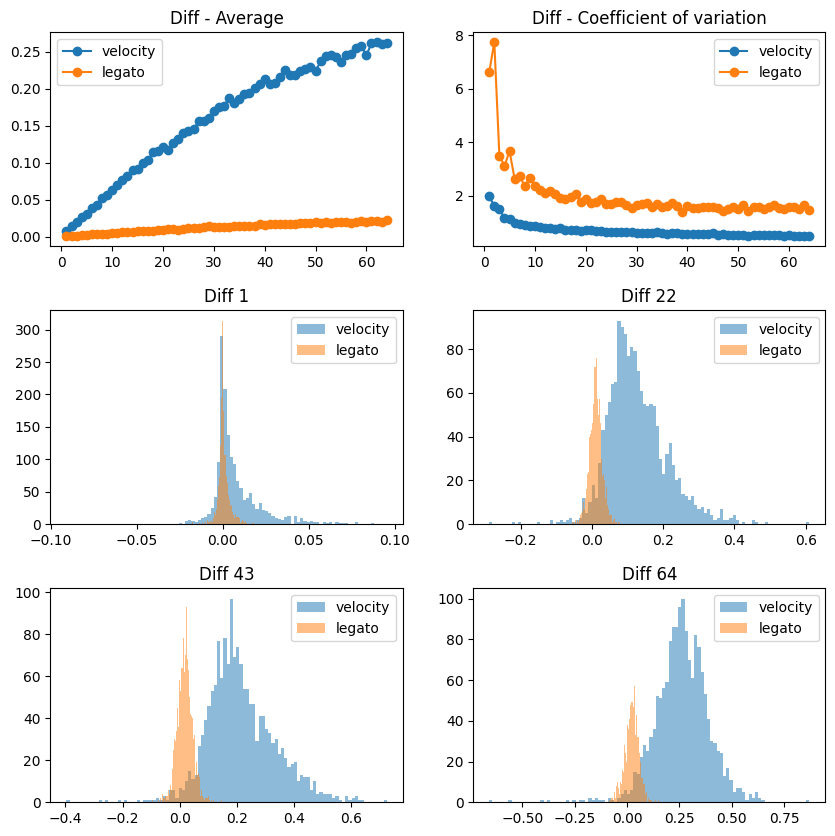

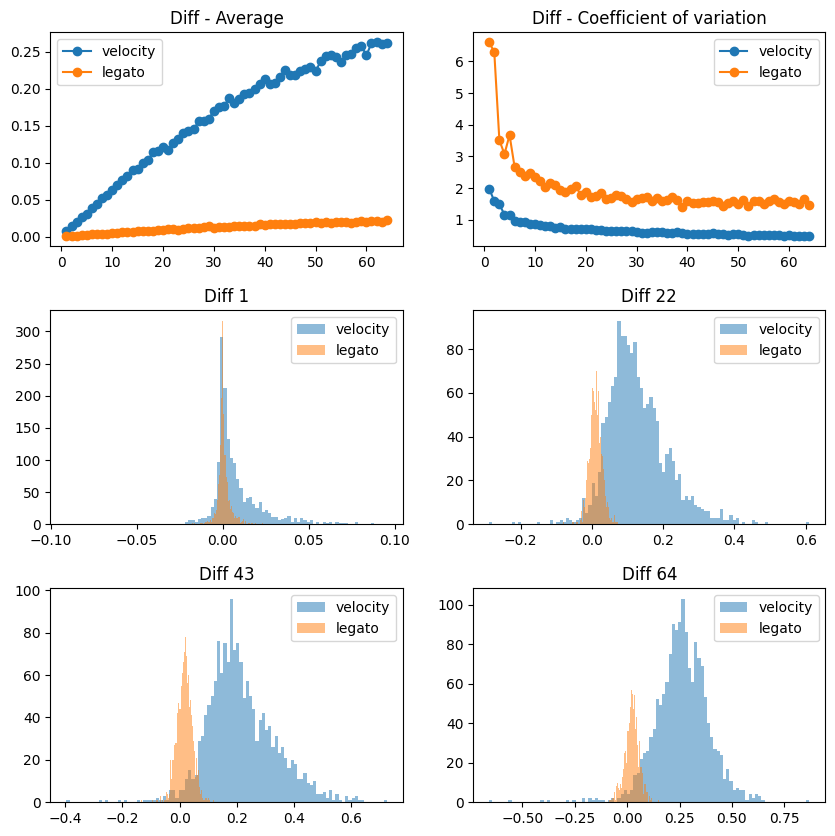

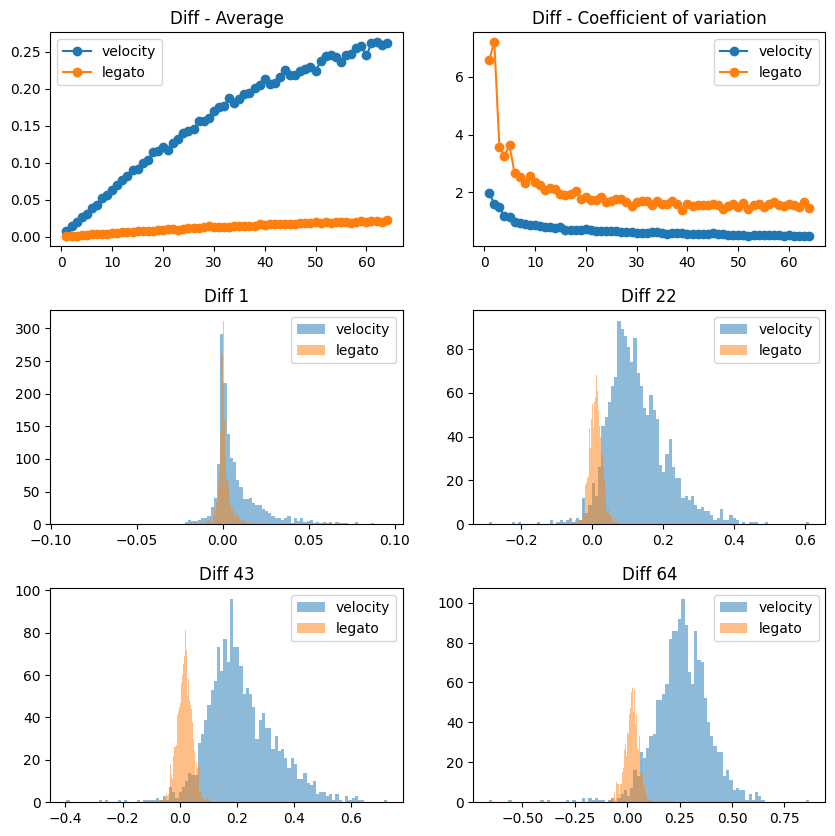

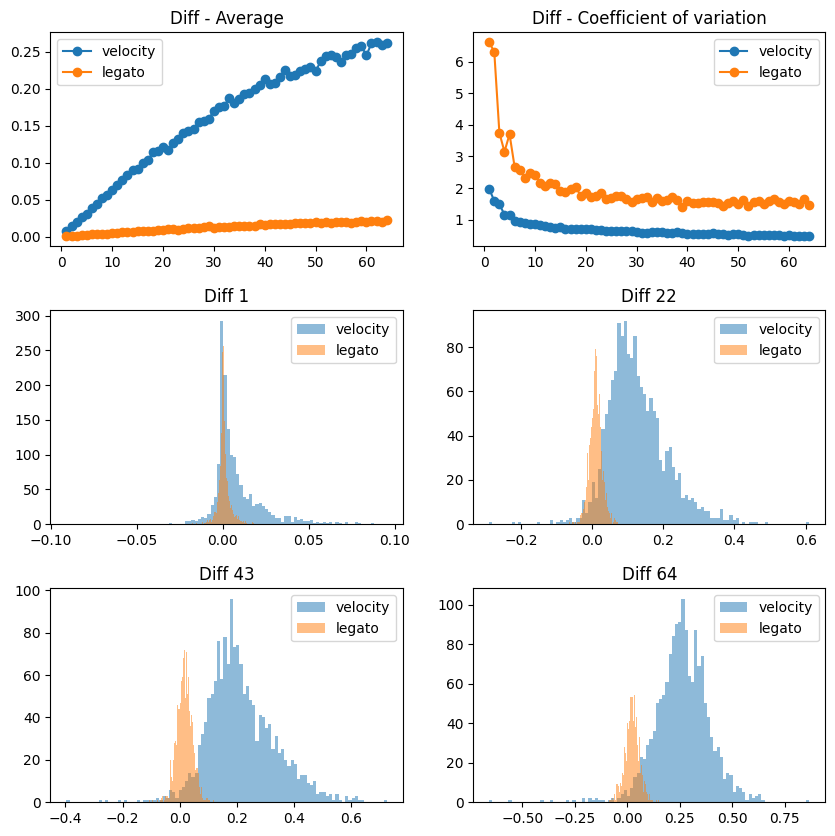

In [8]:
test(absolute_velocities[0], latent_dim[1], noise[2], architecture[4], f'1024', legw=3, epochs=60)